### Imports

In [1]:
# !pip install line_profiler
%load_ext line_profiler
# !pip install py-heat-magic
%load_ext heat

%load_ext autoreload
%autoreload 2

# %xmode verbose

In [2]:
import sys
# FIXME -- Why Those Directories?
sys.path.append("../")
# sys.path.append("../../resultsAnlysis")

In [3]:
from os import path

import typing as t

import copy
import numpy as np
import pandas as pd
import dataframe_image as dfi
import re
from scipy.interpolate import griddata

import matplotlib as mpl
import matplotlib.pyplot as plt

import random
import math
import scipy

In [4]:
from old.resultsAnalysis.numberWithUncertainty import numberWithUncertainty 

from old.resultsAnalysis.classificationError import remove_bin_class_bias
from old.resultsAnalysis.classificationError import remove_bin_class_bias
from old.resultsAnalysis.utils import bubble_sort_dicts_based_on_property 

from data_analysis_utils import *

import config
from config import debug_imgs_path_used, debug_imgs_prefix

In [5]:
# Context-Driven Abbreviations

# FIXME: Change this along code ...
# cs        Color Space
# oob       Out Of Bootrap Evaluation | It's Results
# b_method  Best Method
# summ      Summary
# HP(s)     Hyperparameter(s)
# freq      Frequence

# _p_   per

### DataSets

In [6]:
from typeguard import check_type
from analysisTypes import *

In [7]:
import old.resultsAnalysis.condoAnalysisData as condoAnalysisData

# b = t.dict[str, technique_oriented_df]
v = t.TypeVar("v", bound=t.Union[t.Dict[str, technique_oriented_results_t], t.Dict[str, 'v']])
# x = t.Dict[str, technique_oriented_df] | t.Dict[str, 'v']
# print(type(x))
    
CM_EVAL_2024 = check_type(condoAnalysisData.CIENCIAS_MOLECULARES_EVAL_2024, v)


In [8]:
# FIXME: "pos_correction" because data was wrongly processed At First

# FIXME: Why Renaming To This Format
x = pd.DataFrame(CM_EVAL_2024['Kmeans'])
x = x.rename({
    "KNN_K_0.2n": "knn_clusters_0_2",
    "KNN_K_0.4n": "knn_clusters_0_4",
    "KNN_K_0.6n": "knn_clusters_0_6",
    "KNN_K_0.8n": "knn_clusters_0_8",
    "KNN_K_sqrt_n": "knn_clusters_sqrt",
    "KNN_K_n^2/8": "knn_clusters_exp_2_over_8",
    "KNN_K_n^3/8": "knn_clusters_exp_3_over_8"
}, axis=1)
CM_EVAL_2024['Kmeans'] = x.to_dict()

# CHANGE 'data['Kmeans']["KNN_K_0.2n"]["Kmeans_k_20"]' -> 'data["KNN_K_0.2n_Kmeans_k_20"]'
pos_correction_kmeans_n_init_3 = {}
for KNN_K, subMethodsDict in CM_EVAL_2024['Kmeans'].items():
    for KMEANS_K, method_results in subMethodsDict.items():
        pos_correction_kmeans_n_init_3[f"{KNN_K}_{KMEANS_K}"] = method_results

pos_correction_kmeans_n_init_3 = check_type(pos_correction_kmeans_n_init_3, technique_oriented_results_t)

pos_correction_slic = check_type(CM_EVAL_2024['SLIC_min_max'], technique_oriented_results_t)
pos_correction_mean_sd = check_type(CM_EVAL_2024['mean_sd'], technique_oriented_results_t)

In [9]:
# HP: Hyperparameter
method_key_to_HPs_labels_mapper_per_technique = {
    "K-Means + KNN": {
        "knn_clusters_": "KNN K: ",
         "_Kmeans_k_": " | Kmeans K: ",
        
        "_over_": "/",
        "exp_": "N^",
        "_": "." 
    },
    
    "MinMax-Slic": {
        "SLIC_minmax":"",
        "_spxArea_": "Área Superpixel: ",
        "_m_": "px² | m: ",
        "_": "."
    },
    
    "Mean-SD": {
        "mean_sd_threshold_": "β: ",
        "_":"."
    }
}

def method_key_to_HPs_labels(method_key:str, method_key_to_HPs_labels_mapper:dict[str, str]) -> str:
    """
    Change method_key to Hide the tecnique name and convert HPs from identifier form
    To Display-Label Form
        
    Parameters
    ---------
        method_key (str): 
            A String of format: "technique_name_HPs_description"
        method_key_to_HPs_labels_mapper (dict[str, str]): 
            A Dict Describing how to replace each subString of method_key
            Substring Declared First On The Mapper, Will Be Replaced First

    Returns
    ------
        str: HPs in Display-Label Form
        
    Example
    ------
    >>> method_key = "tecnique_A_alpha_2_3"
    >>> mapper = {
    >>>     "tecnique_A_": "",
            "alpha_": "α: ",
            "_": "."
    >>> }
    >>> method_key_to_HPs_labels(method_key, mapper)
    >>>     returns "α: 2.3"
    """
    
    for HP_separator, HP_Prefix in method_key_to_HPs_labels_mapper.items():
        method_key = method_key.replace(HP_separator, HP_Prefix)
        
    return method_key

In [10]:
methods_options = {
    "K-Means + KNN": {
        "technique_label": "K-Means + KNN Inversa",
        "data": pos_correction_kmeans_n_init_3
    },
    "Mean-SD": {
        "technique_label": "Limiarização Mean-SD",
        "data": pos_correction_mean_sd
    },
    "MinMax-Slic": {
        "technique_label": "SLIC-MinMax",
        "data": pos_correction_slic
    }
}

data: technique_oriented_results_t
technique_label: str
method_key_to_HPs_labels_mapper: t.Dict[str, str]

def set_current_technique_data(technique_name:str):
    global data
    global technique_label
    global method_key_to_HPs_labels_mapper
    
    data = check_type(methods_options[technique_name]["data"], technique_oriented_results_t)
    data = copy.deepcopy(data)

    technique_label = methods_options[technique_name]["technique_label"]

    method_key_to_HPs_labels_mapper = {}
    if technique_name in method_key_to_HPs_labels_mapper_per_technique:
        method_key_to_HPs_labels_mapper = method_key_to_HPs_labels_mapper_per_technique[technique_name]
    


In [11]:
# pos_correction_min_max, pos_correction_slic, pos_correction_mean_sd, pos_correction_kmeans_n_init_3
# Min-Max,                MinMax-Slic,         Mean-SD,              , K-Means + KNN

# technique_name = "K-Means + KNN"
# technique_name = "Mean-SD"
technique_name = "MinMax-Slic"

set_current_technique_data(technique_name)

In [12]:
#TODO: Pre Computação de OOB Vs Visualização

metrics_to_track = ['accuracy', 'balancedAccuracy', 'F1Score', 'time_to_analyze', 'recall', 'specificity', 'precision', 'MCC', 'Ps']
# metrics_to_track = ["MCC", "Ps", "time_to_analyze"]

# sort_metric = "MCC"
# sort_metric = "time_to_analyze"
sort_metric = "Ps"

labels_metrics_to_track = {
    'accuracy': 'Acurácia (%)',
    'balancedAccuracy': 'Acurácia Balanceada (%)',
    'F1Score': 'F1-Score (%)',
    "time_to_analyze": "Duração (s)",
    # "overselectionIndex": "Índice de Sobre-Seleção",
    "recall": "Recall (%)",
    "specificity": "Specificity (%)",
    "precision": "Precisão (%)",
    "MCC": "normMCC (%)",
    "Ps": "Ps (%)",
    # 'truePositiveRate': 'Taxa de Verdadeiro Positivo',
}

In [13]:
f_to_get_metric_from_condo_ds = {}
f_to_get_metric_from_condo_ds["time_to_analyze"] = lambda ds, cache=None: pd.DataFrame(ds)["time_to_analyze"]

# Great Parts of Metric Of Interest Are Inside "classification_evaluation_metrics" property
for metric in ['accuracy', 'balancedAccuracy', 'F1Score', "AUC", "recall", "MCC", "Ps", "specificity", "precision"]:
    
    def create_f(metric):
        def getMetric(condo_ds, cache=None):
            
            if cache == None:
                cache = {}
            
            if not "class_eval_metrics_df" in cache:
                cache["class_eval_metrics_df"] = reduce_df_dim(pd.DataFrame(condo_ds), "classification_evaluation_metrics")
            
            class_eval_metrics_df = cache["class_eval_metrics_df"]
            
            return class_eval_metrics_df[metric]
        
        return getMetric
    
    
    f_to_get_metric_from_condo_ds[metric] = create_f(metric)

In [14]:
# Isso pode ser importante para que se possa iterar por esses arrays e obter apenas métricas válidas
# (disponíveis nos resultados)
# TODO: Deveria ser assim? - Não tem aquele princípio - Poder adicionar sem quebrar (API)

for metric in [*labels_metrics_to_track.keys()]:
    if (not metric in metrics_to_track):
        del labels_metrics_to_track[metric]

for metric in [*f_to_get_metric_from_condo_ds.keys()]:
    if (not metric in metrics_to_track):
        del f_to_get_metric_from_condo_ds[metric]

In [15]:
quality_prop = sort_metric

### Pre-Process Data

In [16]:
# Converts data: from DataFrame[color_space_oriented_df] -> DataFrame[technique_oriented_df]
color_space_oriented_df = pd.DataFrame(data).T

# Remove Excluded Color Spaces (Just "OKLAB_results")
if ("OKLAB_results" in color_space_oriented_df.keys()):
    color_space_oriented_df.drop("OKLAB_results", axis=1, inplace=True)

In [17]:
# Remove Bias: Ignore Correct Classification of Pixels Masked Out Before Segmentation

def update_condo_ds_class_metrics(condo_ds: condo_ds_t):
    for i, condo_data in enumerate(condo_ds):
        new_metrics = remove_bin_class_bias([i, condo_data["classification_evaluation_metrics"]])
        condo_ds[i]["classification_evaluation_metrics"] = new_metrics
        
    return condo_ds

color_space_oriented_df = color_space_oriented_df.apply(
    lambda method_analysis_data:
        method_analysis_data.apply(
            update_condo_ds_class_metrics
    ),
    axis=0
)

In [18]:
# Normalizing Time: 10 Images [0-9] are (1366x768); 4 Images [10-13] are (1830x1080)
# Scale images [10-13] time of processing, so It fits images [0-9] scale (reference images)

ref_img_size = 1366*768
larger_img_size = 1830*1080
time_normalization_const = ref_img_size/larger_img_size
time_normalizaton_vector = np.array([1]*10 + [time_normalization_const]*4)

def normalize_time(DS_data: condo_ds_t):
    DS_data = pd.DataFrame(DS_data)
    DS_data["time_to_analyze"] = DS_data["time_to_analyze"] * time_normalizaton_vector
    return DS_data.to_dict("records")
    
color_space_oriented_df = color_space_oriented_df.apply(lambda col: col.apply(lambda DS: normalize_time(DS)))

In [19]:
# Injecting Msising Metrics: MCC (Matthews correlation coefficient)
from computeMissingMetrics import * 

def inject_missing_metrics(ds: condo_ds_t) -> condo_ds_t:
    ds_df = pd.DataFrame(ds)
    ds_metrics_df = reduce_df_dim(ds_df, "classification_evaluation_metrics")
    confusion_matrix_series = ds_metrics_df["typesDistribution"]

    ### (norm)MCC
    if "MCC" in metrics_to_track:
        MCC = confusion_matrix_series.apply(lambda confusion_matrix: compute_MCC(confusion_matrix))
        ds_metrics_df["MCC"] = (MCC + 1) / 2 * 100 # Normalizing It
    
    ### Ps
    if "Ps" in metrics_to_track:
        ds_metrics_df["Ps"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_pS(confusion_matrix)) * 100
    
    ### Specificity 
    if "specificity" in metrics_to_track:
        ds_metrics_df["specificity"] = confusion_matrix_series.apply(lambda confusion_matrix: compute_specificity(confusion_matrix)) * 100
    
    ds_df["classification_evaluation_metrics"] = ds_metrics_df.to_dict("records")
    return ds_df.to_dict("records")


In [20]:
color_space_oriented_df = color_space_oriented_df.apply(lambda col: col.apply(lambda ds: inject_missing_metrics(ds)))

### Out Of Bootstrap .362+

In [21]:
"""
This Section Goal Is Not To Implement the OOB.362 Completely
It's Cores Logic Was Implemented, but the training using the Training Set Was Ignored
The purpose of this section is to extract the oob samples just for the testing
This will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way
"""

"\nThis Section Goal Is Not To Implement the OOB.362 Completely\nIt's Cores Logic Was Implemented, but the training using the Training Set Was Ignored\nThe purpose of this section is to extract the oob samples just for the testing\nThis will be done to represent the population, but not all the current dataset to fine-tune the hyperparameters in a no biased way\n"

In [22]:
from bootstrap_sampling import *
from oob_results_sampling import *

In [23]:
valid_oob_results_sets_t = t.NewType("valid_oob_results_sets_t",
                                     t.Literal["test"]|t.Literal["eval"]|t.Literal["train"])


method_oob_eval_results_t = t.NewType("method_oob_eval_results_t",
                                        Dict[valid_oob_results_sets_t, t.Dict[str,
                                            t.List[float|int] | # "metric_ds" (DataSet Of The Mean Result On Each Sample)
                                            float] # "metric_mean" (metric_ds mean)
                                        ]
                                    )

oob_eval_results_t = t.NewType("oob_eval_results_t",
                               t.Dict[valid_color_spaces_t, t.Dict[str, method_oob_eval_results_t]])

In [24]:
# oob_results_f_path = f"{technique_name}_oob_samples_results_v5_w_ps.data"
oob_results_f_path = path.join("oobCache", f"{technique_name}_oob_samples_results_v6_05_08_25_w_all_props.data")

def _cache_eval_compute_crr_oob_results(cache:str):
    print("Evaluating Cached OOB Data")
    oob_362_plus_results_over_methods_str = re.sub(r"array\((?=\[[^\]\)]*\])", "np.array(", cache)
    return eval(oob_362_plus_results_over_methods_str)

@cache_result(oob_results_f_path, _cache_eval_compute_crr_oob_results)
def _compute_crr_oob_results(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount=300):
    return compute_oob_362_results_over_methods(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount)

# Previous "oob_362_plus_results_over_methods"
oob_eval_methods_results: oob_eval_results_t
oob_eval_methods_results = _compute_crr_oob_results(color_space_oriented_df, f_to_get_metric_from_condo_ds, sample_amount=300)

Evaluating Cached OOB Data


In [25]:
## Testing: ---
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].iloc[[0, 1]], 2)
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].loc[["knn_clusters_0_2_prop_b_100", "knn_clusters_0_4_prop_b_100"]], 2)
# oob_362_plus_results_over_methods = compute_oob_362_results_over_methods(color_space_oriented_df[["LAB_results"]].loc[["knn_clusters_0_8_Kmeans_k_300"]], 2)

## Test With Individual Method ---
# ds = pos_correction_kmeans_n_init_3["Kmeans_k_300"]["LUV_results"]
# quality_prop = sort_metric

# oob_362_quality_prop_measurement(ds, 400, quality_prop, [], 100)

In [26]:
# Renaming "train" -> "evaluation"
oob_eval_methods_results = pd.DataFrame(oob_eval_methods_results).apply(lambda col: col.apply(lambda ds: pd.DataFrame(ds).rename(columns={"train": "evaluation"}).to_dict()))

In [27]:
def remove_metric_not_of_interest(oob_results):
    for set_type in ["test", "evaluation"]:
        crr_eval_results = pd.DataFrame([oob_results[set_type]])
        
        metrics_mean_keys = map(lambda metric: f"mean_{metric}", metrics_to_track)
        metrics_ds_keys = map(lambda metric: f"{metric}_ds", metrics_to_track)
        
        results_to_maintain = set([*metrics_mean_keys, *metrics_ds_keys]).intersection(crr_eval_results.columns)
        results_to_maintain_df = crr_eval_results[[*results_to_maintain]]
        
        oob_results[set_type] = results_to_maintain_df.to_dict("records")[0]
    return oob_results

oob_eval_methods_results = oob_eval_methods_results.apply(
    lambda col: 
        col.apply(lambda oob_results:
            remove_metric_not_of_interest(oob_results)
        )
    )

### (Set-Up): OOB Best Methods Results And Sample-Frequency

In [28]:
class best_method_info_t(t.TypedDict):
    name: str
    test_results: Dict[str, float|int] #FIXME create custom type

sample_index = t.NewType("sample_index", int)
method_rank = t.NewType("method_rank", int)
best_methods_p_sample_t = t.NewType("best_methods_p_sample_t",
                                    Dict[sample_index, Dict[method_rank, best_method_info_t]])

In [29]:
quality_prop

'Ps'

In [30]:
# FIXME 
def identify_best_methods_p_sample(methods_results_df:pd.DataFrame, top_n_methods_to_look:int=1) -> best_methods_p_sample_t:
    """
    Selects the top_n_methods_to_look best methods for each sample.
    
    The method performance criterion (perf_crit) depends on the quality property being evaluated.
    
    Parameters
    ----------
    methods_results_df : pd.DataFrame
        A DataFrame containing method results with a hierarchical structure where:
        - Rows represent different methods (method names as index)
        - Columns represent analysis sets ("test", "evaluation")
        - Each cell contains a dictionary with metric results including dataset arrays
    
    top_n_methods_to_look : int, default=1
        Number of top-performing methods to identify per sample. Must be >= 1.
    
    Returns
    -------
    dict
        A nested dictionary with the following structure:
        {
            sample_index: {
                method_rank: {
                    "name": str,           # Method name
                    "test_results": dict   # Mean Test metrics Along All Samples (No datasets)
                }
            }
        }
        
        Where:
        - sample_index: int from 0 to number of samples - 1
        - rank: int from 0 to top_n_methods_to_look - 1 (0 = best performing)
        - test_results: Dictionary of metric values for that sample, with dataset 
          array keys (ending in "_ds") removed
    
    Notes
    -----
    Performance criteria by quality property:
    - normPs, Ps: Minimize absolute distance to 50%
    - time_to_analyze: Minimize execution time
    - All other metrics: Maximize metric value
    
    If The Same Method Presents To Be The Best In Multiple Samples,Their 'test_results'
    Will Be equal in ALl Metrics
    """
    
    # Choosed first Eval Results And a Valid Property to compute sample amount
    sample_amount = len(methods_results_df.iloc[0]["test"][f"{quality_prop}_ds"])
    
    best_method_per_sample = {} # Output Dict
    for sample_i in range(sample_amount):
        best_method_per_sample[sample_i] = {}
        
        # Describing What Means to a Sample Has The Best Quality Metric
        # (For each Possible Quality Metric)
        # What is the perf_crit (excellence criterion)
        # And If It's to Max or Min It
        
        # best_excel_crit_df: 
            # Df {"ANALYSIS_SET": "METHOD_NAME": {"test": perf_crit, "evaluation": "perf_crit"}}
            # Each row: a Best method-Result and it's excellence criterion
        best_perf_crit_df: pd.DataFrame
        
        # (Ps): Performance = Minimize Distance To 50%
        if (quality_prop in ["normPs", "Ps"]):
                
            # performance_criteria
            def get_abs_dist_to_0_5(oob_results: oob_eval_results_t):
                return abs(oob_results[f"{quality_prop}_ds"][sample_i]-50)
            
            crr_sample_perf_crit_df = methods_results_df.apply(lambda col: col.apply(get_abs_dist_to_0_5))
            best_perf_crit_df = crr_sample_perf_crit_df.nsmallest(top_n_methods_to_look, "evaluation")
            
        # (Other Metrics): Performance = Max or Min Metric Itself
        else:
            
            # excel_crit
            def get_quality_metric_ds(oob_results):
                return oob_results[f"{quality_prop}_ds"][sample_i]
            
            crr_sample_perf_crit_df = methods_results_df.apply(lambda col: col.apply(get_quality_metric_ds), axis=0)
            
            # (time_to_analyze): Min Time
            if (quality_prop == "time_to_analyze"):
                best_perf_crit_df = crr_sample_perf_crit_df.nsmallest(top_n_methods_to_look, "evaluation")
            
            # (Other): Max Metric
            else:
                best_perf_crit_df = crr_sample_perf_crit_df.nlargest(top_n_methods_to_look, "evaluation")
        
        
        # Generate Output Object for Each Top-N Best Methods
        #    {"name": name, "test_results": {mean of each of metrics_to_track}}     
        # Save It on best_method_per_sample[sample_i][nth_best_method]
        for nth_best_method in range(best_perf_crit_df.shape[0]):     
            best_method_per_sample[sample_i][nth_best_method] = {}
            crr_best_method = best_method_per_sample[sample_i][nth_best_method]
            
            crr_best_result_name = best_perf_crit_df.iloc[nth_best_method].name
            crr_best_method["name"] = crr_best_result_name
            
            # Get Test Results & Remove DSs (They Won't Be Used on This Analysis Pipeline)
            best_method_all_oob_res = methods_results_df.loc[crr_best_result_name]
            test_results = best_method_all_oob_res.loc["test"]
            
            DSs_keys = [*map(lambda prop: f"{prop}_ds", metrics_to_track)]
            test_results = pd.DataFrame(test_results).drop(DSs_keys, axis=1).iloc[sample_i].to_dict()
            
            crr_best_method["test_results"] = test_results
            
    return best_method_per_sample

In [31]:
# Along All Eval OOB samples, the same method can be identified as the best one multiple times
# The mean test quality is estimated along these multiple times
# The rate in which each method is said the best (compared to total OOB samples) is computed 

# def compute_test_quality_metrics_and_best_metric_frequency(oob_results):
#TODO: CHANGE NAME
def summary_unique_b_method_from_oob(b_methods_p_sample: best_methods_p_sample_t) -> pd.DataFrame:
    """
    Calculate summary statistics
    for each UNIQUE methods that performed best across on at least 1 OOB sample.
    
    Including (Classification Metrics Mean) and OOB-Samples Frequence In Which the method
    was a best bethod 
    
    Parameters
    ----------
    b_methods_p_sample : best_methods_per_sample_t
        Dict Data-Frame Like containing the best-performing method for each OOB sample.

    Returns
    -------
    pd.DataFrame
        Summary DataFrame with methods as index and the following columns:
        - Mean metric columns: Average performance across all samples where this
          method was best (column names depend on metrics_to_track)
        - 'Was The Best in How Many Samples': Percentage of samples where this
          method performed best (0-100%)
        
        DataFrame is sorted in descending order by the frequency of being best.
    
    Notes
    -----
    - The function assumes that 'test_results' contains identical mean metrics
      across all samples for the same method, using only the first occurrence
    - Percentages are rounded to 2 decimal places
    - The function displays intermediate results for debugging purposes
    
    Examples
    --------
    >>> # Assume best_methods_summary contains bootstrap results
    >>> summary_df = summary_best_methods_mean_metrics_and_freq(bootstrap_results)
    >>> print(summary_df.columns)
    Index(['mean_accuracy', 'mean_f1', 'Was The Best in How Many Samples'])
    >>> print(summary_df.head())
                           mean_accuracy  mean_f1  Was The Best in How Many Samples
    meanSD_HP1              0.92     0.89                              45.50
    SLIC_MINMAX_HP2         0.89     0.85                              32.25
    """
    
    top_methods_names = [*b_methods_p_sample["name"].unique()]

    # best_methods_mean_results: {"Method_Name": DataFrame[Mean_Results]}
    best_methods_mean_results: t.Dict[str, pd.DataFrame] = {}

    for crr_top_method_name in top_methods_names:

        # Returns 1 Row / Samples in which 'crr_top_method_name' had the best results 
        # "test_results" content of all rows are equal, and represents the mean results of all samples
        # So the 0th row, what used as a valid row 
        crr_top_method_entries = b_methods_p_sample.loc[b_methods_p_sample["name"] == crr_top_method_name]
        crr_top_method_mean_results = reduce_df_dim(crr_top_method_entries, "test_results")
        crr_top_method_mean_results = crr_top_method_mean_results.iloc[0]
        
        crr_top_method_mean_results["Was The Best in How Many Samples"] = crr_top_method_entries.shape[0]
        best_methods_mean_results[crr_top_method_name] = crr_top_method_mean_results
    

    best_methods_mean_results = pd.DataFrame(best_methods_mean_results).T

    # Converting Sample Amount to %
    sample_amount_col = best_methods_mean_results["Was The Best in How Many Samples"]
    
    total_of_samples = sample_amount_col.sum()
    sample_amount_col = 100 * sample_amount_col / total_of_samples
    sample_amount_col = sample_amount_col.apply(lambda val: round(float(val), 2))
    
    best_methods_mean_results["Was The Best in How Many Samples"] = sample_amount_col
    
    # Put mean_results_for_best_methods in Descending order
    mean_results_for_best_methods_ordered = best_methods_mean_results.nlargest(best_methods_mean_results.shape[0], "Was The Best in How Many Samples")
    
    return mean_results_for_best_methods_ordered

In [32]:
# Best Results Per Sample (b_method_per_sample)
# Depends On The Evaluation Scope

# Analysis Will Focus on 2 Scopes:
# 1º: Color Space Scope
#   - "What are the best method in each color space?"
cs_b_method_p_sample = None
# 2º: Global Scope
#   - "Among All Tuples Of (Color Space, Techinique, Hyperparameter), which method is the best?"
oob_eval_methods_results_unpacked = None

# unique_b_methods_summ_ranked_by_freq store the
# Summary of Best Methods On Each Scope (Global / Each Color Space)
unique_b_methods_summ_ranked_by_freq = {}

# - Tecnique for (K-Means, ...)
# - Method for (Techinique, Hyperparameter)

In [33]:
# best_method_per_sample is Separated By Color Space
cs_b_method_p_sample = {}

for color_space in [*oob_eval_methods_results.keys()]:
    all_methods_df = reduce_df_dim(oob_eval_methods_results, color_space)
    cs_b_method_p_sample[color_space] = identify_best_methods_p_sample(all_methods_df, top_n_methods_to_look=1)

In [34]:
# Modify oob_eval_methods_results ( DataFrame[{color_space: {method: eval_results}}] )
# Remove Color Spaces Columns
    # And Maintain it as a prefix of method name
    # ('method_name' -> 'color_space method_name')
# Make eval_results keys became the columns of The DataFrame

oob_eval_methods_results_unpacked = pd.DataFrame()
for color_space in oob_eval_methods_results.keys():
    crr_results = oob_eval_methods_results[color_space]
    
    # Remove Columns Name (Get Data and Recreate Series to Remove Metadata)
    crr_results = pd.Series(crr_results.to_dict())
    
    # Prefix Method Name w/ Color Space 
    rm_results_prefix = lambda method_name: f"{color_space.replace("_results", "")} {method_name}"
    formatted_eval_methods_results = crr_results.rename(rm_results_prefix)
    
    # Concat Alredy Indexed Color Spaces, W/ Current One
    oob_eval_methods_results_unpacked = pd.concat([oob_eval_methods_results_unpacked, formatted_eval_methods_results])
    
    # all_color_spaces_best_methods_per_sample = pd.concat([all_color_spaces_best_methods_per_sample, delete_series_name(evaluated_methods_results[color_space].rename(lambda method_name: f"{color_space.replace("_results", "")} {method_name}"))])

# Make eval_results keys became the columns of The DataFrame
oob_eval_methods_results_unpacked = reduce_df_dim(oob_eval_methods_results_unpacked, 0)

# Get Best Methods
b_method_p_sample_global = identify_best_methods_p_sample(oob_eval_methods_results_unpacked, top_n_methods_to_look=1)

In [37]:
def rename_metrics_cols_from_keys_to_labels(df:pd.DataFrame):
    sample_amout_label_map = {"Was The Best in How Many Samples": "Melhor Método em Amostras (%)"}
    df_cols_names_mapper = {**labels_metrics_to_track, **sample_amout_label_map}
    
    return df.rename(lambda col_name: df_cols_names_mapper[col_name.replace("mean_", "")], axis=1)

### Best Methods Global Scope: Summary & Color Space Prevalence

In [38]:
max_methods_to_render_on_saved_df = 5

In [61]:
# With best Method of each sample (on eval set) on Global Scope - b_method_p_sample_global
# Summarize Unique Best Methods and Sort Them By "Best Method Frequency"
# Export the Top N Best Method to an External File
# Print The Distribution Of Best Methods Along Color Spaces

# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

global_oob_b_methods_p_sample = (pd.DataFrame(b_method_p_sample_global)
                            .T
                            .pipe(reduce_df_dim, 0))

# summary_unique_b_method_from_oob return is alredy ranked by frequency
unique_b_methods_summ = summary_unique_b_method_from_oob(global_oob_b_methods_p_sample)
unique_b_methods_summ_ranked_by_freq["All Color Spaces"] = unique_b_methods_summ.to_dict("index")

# # If DSs Removal at identify_best_methods_p_sample do not Happens
# # This Line Would Be Necessary to Filter Out the DSs from Renderization
display_columns = ["Was The Best in How Many Samples", *[f"mean_{prop}" for prop in metrics_to_track]]
unique_b_methods_summ = unique_b_methods_summ[display_columns]

# Presentation / Render Pipeline
unique_b_methods_summ = rename_metrics_cols_from_keys_to_labels(unique_b_methods_summ)

# Rename Rows To Hide Techinique (All Tecniques Are The Same = tecnique_name)
# And Put HyperParameters (HPs) On Display (label) form
unique_b_methods_summ = unique_b_methods_summ.rename(
    lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper)
)

# Save To File, The Top (max_methods_to_render_on_saved_df) 
# Unique Best Methods Summaries
methods_to_render_amount = min(max_methods_to_render_on_saved_df, unique_b_methods_summ.shape[0])

#FIXME Mudar o Título
#FIXME: No Path está se dizendo que eu tirei os resultado do test set, verificar
await dfi.export_async(
    unique_b_methods_summ
    .iloc[[*range(methods_to_render_amount)]]
    .style
        .set_caption("Melhor Resultado Entre todos HPs e Espaços de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./{sort_metric}/{technique_name}/All-Color-Space - {technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png",
)

# Print % Of Best Method For Each Color SPace
print()
#FIXME Melhorar esse TExto e talvez o "Melhor Método em Amostras (%)" tbm ...
print("How Much % of Best Methods Were From Each Color Space?")
print("-------")

# Filter, Best Methods By Color Spaces (CS)
# FIXME: QUal o nome desse índice?
# Changing Indexes "CS METHOD HPs"  -> "CS"
# By Maintaining only 0th substring separated by space (CS)

extract_cs_from_index = lambda name: name.split(" ")[0]
unique_b_methods_summ_reindex_as_cs = unique_b_methods_summ.copy()
unique_b_methods_summ_reindex_as_cs["Color Space"] = [*map(extract_cs_from_index, [*unique_b_methods_summ_reindex_as_cs.index])]

cs_best_methods_distribution = (unique_b_methods_summ_reindex_as_cs
                                .groupby("Color Space")
                                .sum()
                                .nlargest(unique_b_methods_summ_reindex_as_cs.shape[0], "Melhor Método em Amostras (%)")
                                [["Melhor Método em Amostras (%)"]]
                                )   

await dfi.export_async(
    cs_best_methods_distribution
    .style
        .set_caption("[Global] Distribuíção dos Melhores Métodos entre Os Espaços de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./{sort_metric}/{technique_name}/All-Color-Space - {technique_name} - {color_space} - Best Methods Distribution Along Color Spaces.png",
)

print(cs_best_methods_distribution)
print("")
print("ALL")
print("-------")
display(unique_b_methods_summ)
print("")



How Much % of Best Methods Were From Each Color Space?
-------
             Melhor Método em Amostras (%)
Color Space                               
RGB                                  74.01
LAB                                  26.00

ALL
-------


,Melhor Método em Amostras (%),Acurácia (%),Acurácia Balanceada (%),F1-Score (%),Duração (s),Recall (%),Specificity (%),Precisão (%),normMCC (%),Ps (%)
RGB Área Superpixel: 400px² | m: 200,46.67,76.762 ± 2.079,76.937 ± 2.32,50.441 ± 4.831,19.621 ± 2.104,78.69 ± 3.869,75.099 ± 2.659,39.451 ± 5.288,70.962 ± 2.216,56.993 ± 4.585
RGB Área Superpixel: 25px² | m: 10,16.00,76.05 ± 1.885,76.315 ± 2.514,49.381 ± 5.042,324.204 ± 38.547,78.122 ± 4.284,74.428 ± 2.236,38.511 ± 5.398,70.319 ± 2.32,58.563 ± 4.598
LAB Área Superpixel: 400px² | m: 50,11.67,80.598 ± 1.602,75.726 ± 1.673,51.541 ± 4.609,25.764 ± 3.476,68.889 ± 3.953,82.435 ± 2.36,46.774 ± 6.093,71.844 ± 1.881,37.887 ± 5.513
RGB Área Superpixel: 400px² | m: 10,10.67,75.868 ± 1.931,75.907 ± 2.47,49.161 ± 5.067,18.467 ± 1.706,77.654 ± 4.126,74.087 ± 2.24,38.201 ± 5.338,70.107 ± 2.315,58.115 ± 4.481
LAB Área Superpixel: 400px² | m: 75,8.33,80.743 ± 1.572,75.887 ± 1.633,51.789 ± 4.582,33.382 ± 1.903,69.191 ± 3.979,82.451 ± 2.372,47.032 ± 6.02,71.995 ± 1.84,37.968 ± 5.492
LAB Área Superpixel: 400px² | m: 200,6.00,80.29 ± 1.468,75.265 ± 1.334,51.117 ± 4.443,23.107 ± 2.273,68.537 ± 3.455,81.879 ± 2.314,46.036 ± 5.95,71.411 ± 1.721,37.544 ± 5.247
RGB Área Superpixel: 225px² | m: 200,0.67,76.627 ± 2.063,77.005 ± 2.476,50.387 ± 4.804,35.659 ± 3.374,78.996 ± 4.072,74.933 ± 2.582,39.312 ± 5.229,70.909 ± 2.237,58.14 ± 4.596


### Results of Methods That Was the Best Most times (Color Spaces Competing with itself)

In [41]:
# For The Best Methods Identified for each eval set
# Quantify the mean quality metrics Estimated for the Test sets
# Quantify the rate in which each methods was said the best for the bootrap sample

for color_space in [*cs_b_method_p_sample.keys()]:
# for color_space in [[*cs_b_method_p_sample.keys()][0]]:
    
    cs_oob_b_methods_p_sample = (pd.DataFrame(cs_b_method_p_sample)
                                .pipe(reduce_df_dim, color_space)
                                .pipe(reduce_df_dim, 0)
                                )
    
    # summary_unique_b_method_from_oob return is alredy ranked by frequency
    unique_b_methods_summ = summary_unique_b_method_from_oob(cs_oob_b_methods_p_sample)
    unique_b_methods_summ_ranked_by_freq[color_space] = unique_b_methods_summ.to_dict("index")
    
    
    # Rounding 2-Decimal-Places
    # FIXME Why not mean time
    # FIXME - Why use {val:.2f} with "Was The Best in How Many Samples"?
    cols_2_round = ~unique_b_methods_summ.columns.isin(["mean_time_to_analyze"])
    round_cells_vals = lambda col: col.apply(lambda val: round(val, 2))
    
    unique_b_methods_summ.iloc[:, cols_2_round] = unique_b_methods_summ.iloc[:, cols_2_round].apply(round_cells_vals)
    # unique_b_methods_summ["Was The Best in How Many Samples"] = unique_b_methods_summ["Was The Best in How Many Samples"].apply(lambda val: f"{val:.2f}")
    
    # Rename Rows To Hide Techinique (All Tecniques Are The Same = tecnique_name)
    # And Put HyperParameters (HPs) On Display (label) form
    unique_b_methods_summ = rename_metrics_cols_from_keys_to_labels(unique_b_methods_summ)
    mean_results_for_best_methods_to_render = unique_b_methods_summ.rename(lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper)
    )
    
    # Save To File, The Top (max_methods_to_render_on_saved_df) 
    # Unique Best Methods Summaries
    methods_to_render_amount = min(max_methods_to_render_on_saved_df, unique_b_methods_summ.shape[0])
    await dfi.export_async(
        mean_results_for_best_methods_to_render
        .iloc[[*range(methods_to_render_amount)]]
        .style
            .set_caption(color_space.replace("_results", ""))
            .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
        ,
        f"./{sort_metric}/{technique_name}/{technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png"
    )
    
    # Logging Results Std Output
    print("")
    print(color_space)
    print("-------")
    display(unique_b_methods_summ)
    print("")


SHLS_results
-------


,Specificity (%),Acurácia Balanceada (%),Acurácia (%),Recall (%),normMCC (%),F1-Score (%),Ps (%),Precisão (%),Duração (s),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_10,88.83 ± 1.64,75.85 ± 2.61,85.72 ± 1.52,62.67 ± 5.65,73.92 ± 2.43,55.99 ± 5.13,26.92 ± 5.13,53.12 ± 5.12,11.553 ± 0.943,80.0
SLIC_minmax_spxArea_400_m_200,89.41 ± 1.62,76.73 ± 2.19,86.45 ± 1.42,63.89 ± 4.99,75.06 ± 2.06,57.5 ± 4.67,26.3 ± 5.02,55.83 ± 4.68,25.204 ± 2.926,20.0




SHSV_results
-------


,Specificity (%),Acurácia Balanceada (%),Acurácia (%),Recall (%),normMCC (%),F1-Score (%),Ps (%),Precisão (%),Duração (s),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_10,88.81 ± 1.65,76.09 ± 2.44,85.83 ± 1.48,63.18 ± 5.37,74.28 ± 2.39,56.64 ± 5.02,27.29 ± 5.47,53.59 ± 5.4,11.825 ± 0.926,64.00
SLIC_minmax_spxArea_400_m_200,89.2 ± 1.68,76.59 ± 2.34,86.31 ± 1.5,63.79 ± 5.29,74.79 ± 2.27,57.18 ± 4.98,26.83 ± 5.29,54.68 ± 4.96,26.299 ± 1.88,35.00
SLIC_minmax_spxArea_400_m_20,89.78 ± 1.52,76.89 ± 2.37,86.6 ± 1.41,63.82 ± 5.2,75.08 ± 2.26,57.77 ± 4.84,25.93 ± 4.87,55.33 ± 5.13,18.058 ± 1.133,0.67
SLIC_minmax_spxArea_400_m_30,90.03 ± 1.67,77.6 ± 2.33,86.87 ± 1.59,65.01 ± 4.96,76.18 ± 2.12,59.57 ± 4.54,25.34 ± 4.75,58.75 ± 4.75,14.902 ± 1.225,0.33




LAB_results
-------


,Specificity (%),Acurácia Balanceada (%),Acurácia (%),Recall (%),normMCC (%),F1-Score (%),Ps (%),Precisão (%),Duração (s),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_75,82.45 ± 2.37,75.89 ± 1.63,80.74 ± 1.57,69.19 ± 3.98,72.0 ± 1.84,51.79 ± 4.58,37.97 ± 5.49,47.03 ± 6.02,33.382 ± 1.903,45.67
SLIC_minmax_spxArea_400_m_50,82.43 ± 2.36,75.73 ± 1.67,80.6 ± 1.6,68.89 ± 3.95,71.84 ± 1.88,51.54 ± 4.61,37.89 ± 5.51,46.77 ± 6.09,25.764 ± 3.476,37.00
SLIC_minmax_spxArea_400_m_200,81.88 ± 2.31,75.26 ± 1.33,80.29 ± 1.47,68.54 ± 3.45,71.41 ± 1.72,51.12 ± 4.44,37.54 ± 5.25,46.04 ± 5.95,23.107 ± 2.273,17.00
SLIC_minmax_spxArea_225_m_200,82.48 ± 2.24,74.89 ± 1.53,80.47 ± 1.43,67.17 ± 3.85,71.19 ± 1.74,50.6 ± 4.44,36.66 ± 5.25,46.09 ± 5.92,48.372 ± 5.11,0.33




LUV_results
-------


,Specificity (%),Acurácia Balanceada (%),Acurácia (%),Recall (%),normMCC (%),F1-Score (%),Ps (%),Precisão (%),Duração (s),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_75,87.34 ± 2.19,78.27 ± 1.79,85.34 ± 1.64,69.12 ± 3.38,75.75 ± 2.0,59.38 ± 4.12,29.1 ± 5.01,54.94 ± 5.5,40.862 ± 3.583,48.67
SLIC_minmax_spxArea_400_m_100,87.08 ± 2.25,77.68 ± 1.87,85.01 ± 1.69,68.2 ± 3.53,75.2 ± 2.08,58.4 ± 4.25,29.08 ± 5.02,54.02 ± 5.63,30.851 ± 2.866,17.33
SLIC_minmax_spxArea_400_m_200,86.9 ± 2.26,77.29 ± 1.84,84.83 ± 1.68,67.58 ± 3.49,74.86 ± 2.08,57.91 ± 4.31,28.88 ± 4.93,53.47 ± 5.62,25.32 ± 1.652,17.33
SLIC_minmax_spxArea_225_m_200,87.2 ± 2.2,77.67 ± 2.06,84.98 ± 1.72,68.04 ± 3.77,75.22 ± 2.18,58.49 ± 4.4,28.88 ± 4.9,54.2 ± 5.64,34.624 ± 2.96,15.33
SLIC_minmax_spxArea_225_m_100,87.58 ± 2.19,78.06 ± 2.01,85.32 ± 1.7,68.46 ± 3.71,75.66 ± 2.13,59.22 ± 4.28,28.5 ± 4.96,55.08 ± 5.57,34.701 ± 2.662,1.33




RGB_results
-------


,Specificity (%),Acurácia Balanceada (%),Acurácia (%),Recall (%),normMCC (%),F1-Score (%),Ps (%),Precisão (%),Duração (s),Melhor Método em Amostras (%)
SLIC_minmax_spxArea_400_m_200,75.1 ± 2.66,76.94 ± 2.32,76.76 ± 2.08,78.69 ± 3.87,70.96 ± 2.22,50.44 ± 4.83,56.99 ± 4.59,39.45 ± 5.29,19.621 ± 2.104,69.67
SLIC_minmax_spxArea_25_m_10,74.43 ± 2.24,76.31 ± 2.51,76.05 ± 1.88,78.12 ± 4.28,70.32 ± 2.32,49.38 ± 5.04,58.56 ± 4.6,38.51 ± 5.4,324.204 ± 38.547,18.33
SLIC_minmax_spxArea_400_m_10,74.09 ± 2.24,75.91 ± 2.47,75.87 ± 1.93,77.65 ± 4.13,70.11 ± 2.31,49.16 ± 5.07,58.11 ± 4.48,38.2 ± 5.34,18.467 ± 1.706,11.33
SLIC_minmax_spxArea_225_m_200,74.93 ± 2.58,77.0 ± 2.48,76.63 ± 2.06,79.0 ± 4.07,70.91 ± 2.24,50.39 ± 4.8,58.14 ± 4.6,39.31 ± 5.23,35.659 ± 3.374,0.67


### Correlation Between HPs & Quality Metric

In [42]:
# print(["SLIC_minmax_spxArea_400_m_10"])

# ANALYSIS_SET = "evaluation"
color_spaces_names = [*oob_eval_methods_results.keys()]
quality_metric_along_oob_samples_on_color_spaces = {color_space: [] for color_space in color_spaces_names}

results_separated_by_method = oob_eval_methods_results.T

for method in results_separated_by_method:
    method_results_separated_by_set = reduce_df_dim(results_separated_by_method, method)
    eval_method_results = reduce_df_dim(method_results_separated_by_set, "evaluation")
    
    quality_metric_DSs = eval_method_results[[f"{quality_prop}_ds"]].to_dict("index")
    for color_space in quality_metric_DSs.keys():
        crr_quality_ds = quality_metric_DSs[color_space][f"{quality_prop}_ds"]
        quality_metric_along_oob_samples_on_color_spaces[color_space].extend(crr_quality_ds)

In [43]:
print(f"Color Spaces: {color_spaces_names}")
print(f"{quality_metric_along_oob_samples_on_color_spaces}")
cov_matrix = np.corrcoef(np.array([*quality_metric_along_oob_samples_on_color_spaces.values()]))
cov_matrix = pd.DataFrame(cov_matrix)
cov_matrix = cov_matrix.rename({idx: name for idx, name in enumerate([*quality_metric_along_oob_samples_on_color_spaces.keys()])}, axis=1)
cov_matrix = cov_matrix.rename({idx: name for idx, name in enumerate([*quality_metric_along_oob_samples_on_color_spaces.keys()])}, axis=0)

# Removing Values Aside of Main Diagonal
cov_matrix = cov_matrix.where(np.tril(np.ones(cov_matrix.shape), k=-1).astype(bool), "")

display(cov_matrix)
cov_matrix.to_latex(f"{technique_label}_correlation_matrix.txt")

Color Spaces: ['SHLS_results', 'SHSV_results', 'LAB_results', 'LUV_results', 'RGB_results']
{'SHLS_results': [np.float64(17.51533589), np.float64(26.3913193), np.float64(26.43647106), np.float64(16.4756694), np.float64(28.05696769), np.float64(28.65165842), np.float64(22.63812686), np.float64(29.36478294), np.float64(29.00927566), np.float64(31.62710083), np.float64(23.18214485), np.float64(32.10245684), np.float64(21.7664815), np.float64(27.3122186), np.float64(29.8833853), np.float64(18.56617903), np.float64(21.39126934), np.float64(29.56677226), np.float64(28.02323338), np.float64(26.01020396), np.float64(21.77276342), np.float64(26.49700095), np.float64(23.397228), np.float64(20.73103573), np.float64(20.35404101), np.float64(26.72164982), np.float64(30.34745884), np.float64(28.06848215), np.float64(29.21973403), np.float64(30.59397708), np.float64(26.38486826), np.float64(25.04998934), np.float64(27.42632001), np.float64(30.57830084), np.float64(25.37623968), np.float64(31.68636531

,SHLS_results,SHSV_results,LAB_results,LUV_results,RGB_results
SHLS_results,,,,,
SHSV_results,0.985987,,,,
LAB_results,0.40149,0.380011,,,
LUV_results,0.630619,0.602866,0.76065,,
RGB_results,0.440267,0.451742,0.401998,0.556278,


In [44]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3_dim_HPs_Quality_metric(result_points, min_quality, max_quality):
    
    for idx in range(len(result_points)-1, -1, -1):
        if (idx <= 0):
            break
        
        prop_a_1, prop_b_1, quality_metric_1 = result_points[idx]
        prop_a_2, prop_b_2, quality_metric_2 = result_points[idx-1]
        
        delta = max_quality - min_quality
        quality_metric_1 = float(quality_metric_1 - min_quality) / delta * 100
        quality_metric_2 = float(quality_metric_2 - min_quality) / delta * 100
        
        mean_quality_metric = (quality_metric_1 + quality_metric_2) / 2
        
        
        x_coord = [prop_a_1, prop_a_2]
        y_coord = [prop_b_1, prop_b_2]
        
        if (technique_name == "K-Means + KNN"):
            # d = float(mean_quality_metric/100-0.72)/0.03
            d = float(mean_quality_metric/100)
        elif (technique_name == "MinMax-Slic"):
            # d = float(mean_quality_metric)/100 * 16
            d = float(mean_quality_metric)/100 
            
        plt.plot(x_coord, y_coord, color=[d, d, d, 1.0])
        plt.scatter(x_coord, y_coord, s=(d*10)**3.2, color=f"{(d**1.2)}")
        # plt.plot(x_coords, y_coords, color=colors, label=color_space)
    
    
def plot_3D_surface_HP_quality_metric(x, y, z, interpolation="nearest", view_init=None, figsize=(10, 6)):
    # x = methods_results["area"].astype("float")
    # y = methods_results["m"].astype("float")
    # z = methods_results[f"mean_{quality_prop}"].astype("float")

    # Criando uma grade regular no domínio de x e y
    grid_x, grid_y = np.meshgrid(
        np.linspace(min(x), max(x), 50),  # 50 pontos entre o mínimo e máximo de x
        np.linspace(min(y), max(y), 50)  # 50 pontos entre o mínimo e máximo de y
    )

    # Interpolação dos valores z para preencher a grade
    grid_z = griddata((x, y), z, (grid_x, grid_y), method=interpolation)  # Opções: 'linear', 'cubic', 'nearest'

    # Criando a figura e o eixo 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect="equal", projection='3d')

    # Plotando a superfície
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z,
        cmap=plt.cm.viridis,  # Colormap para colorir a superfície
        edgecolor='none'  # Sem linhas de grade
    )
    
    if (not view_init is None):
        ax.view_init(*view_init)
    
    ax.set_box_aspect([1, 1, 0.12])  # Adjust aspect ratio if needed
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 1, 0.6, 1]))


    # Adicionando barra de cores
    colorbar = fig.colorbar(surf, ax=ax, shrink=.5, aspect=10, pad=.005)
    colorbar.set_label(labels_metrics_to_track[quality_prop], loc="center", labelpad=8)
    colorbar.ax.yaxis.set_label_position('left') 

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    # ax.scatter(x, y, z, c="0", linewidth=0.5)
    # norm_viridis = ax.pcolormesh(x, y, z, vmin=z.min(), vmax=z.max(), cmap='viridis')
    # print(norm_viridis)
    original_cmap = plt.cm.viridis  # Colormap original
    colors = original_cmap(np.linspace(0, 1, 256*2))
    # colors[:, :3] *= 0.85  # Reduz os valores RGB para escurecer
    colors[:, :3] *= 0.75  # Reduz os valores RGB para escurecer
    darker_cmap = mpl.colors.LinearSegmentedColormap.from_list("DarkerViridis", colors)
    ax.scatter(x, y, z, c=z, cmap=darker_cmap, norm=mpl.colors.Normalize( vmin=z.min(), vmax=z.max()), linewidth=0.5)
    
    # ax.plot_trisurf(x.astype("float"), y.astype("float"), z.astype("float"), cmap=plt.cm.viridis, edgecolor='none')
    # plt.show()
    return fig, ax
    

a


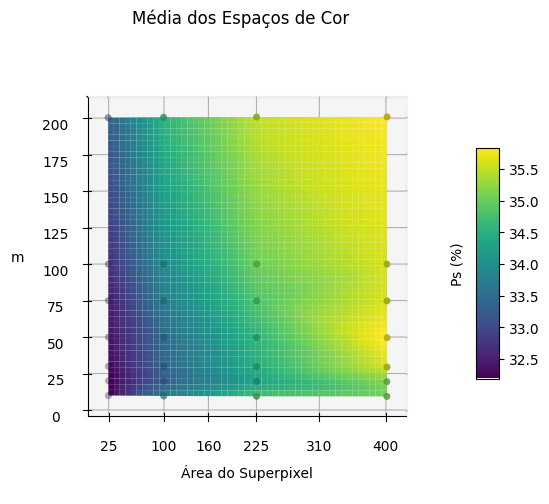

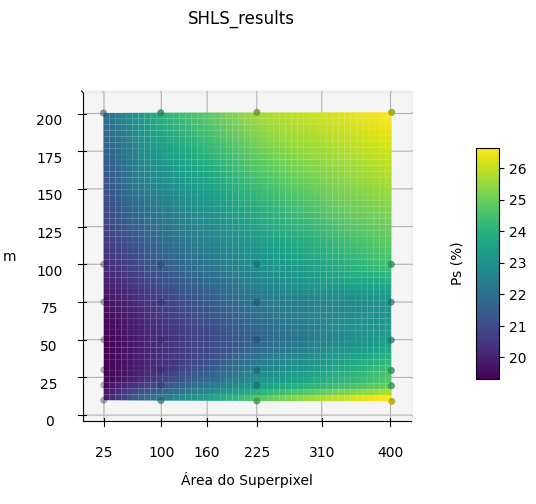

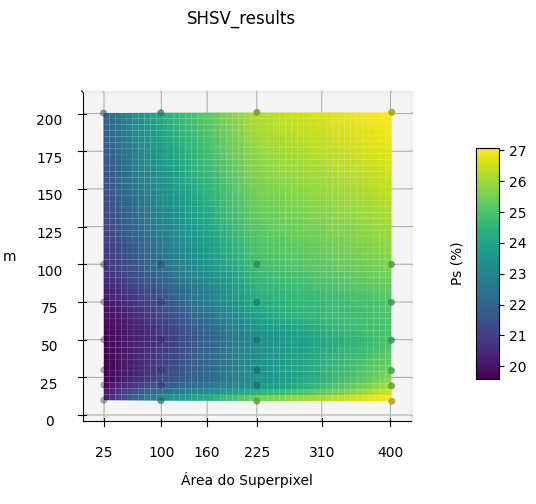

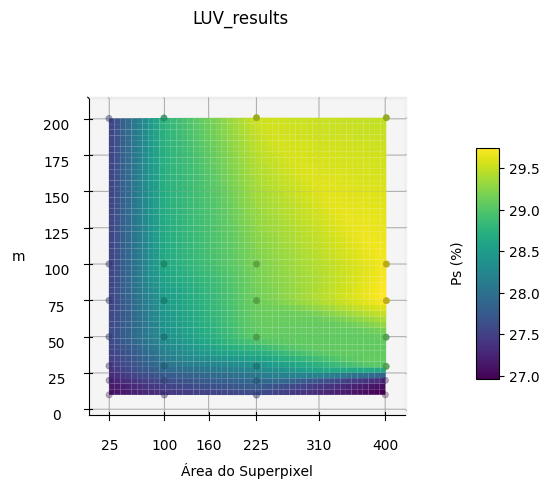

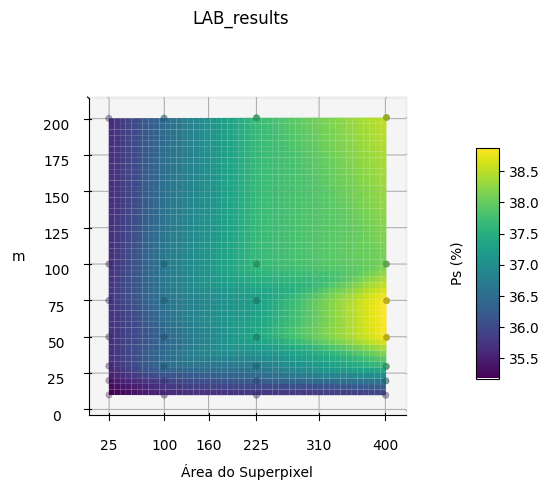

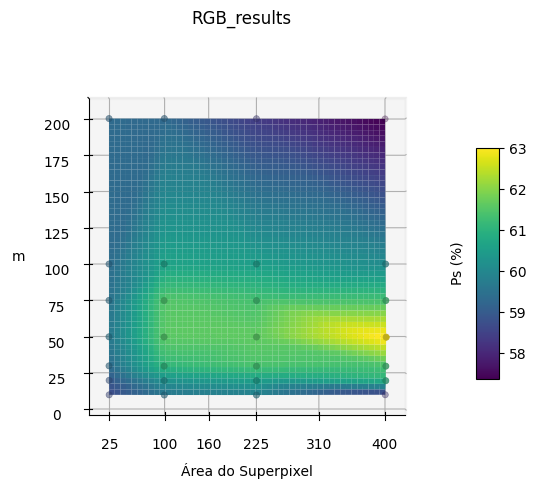

In [45]:

# for color_space in [oob_362_plus_results_over_methods.keys()[1]]:
# for color_space in [*oob_362_plus_results_over_methods.keys()]:
# for i, color_space in enumerate(["Média dos Espaços de Cor"]):
for i, color_space in enumerate(["Média dos Espaços de Cor", "SHLS_results", "SHSV_results", "LUV_results", "LAB_results", "RGB_results"]):
# for i, color_space in enumerate(["SHLS_results", "SHSV_results", "LUV_results", "LAB_results", "RGB_results"]):
    SORTING_ANALYSIS_SET = "evaluation"
    
    if (color_space == "Média dos Espaços de Cor"):
        # all_colorspaces_methods_results = oob_362_plus_results_over_methods.copy().T
        methods_results = pd.DataFrame()
        methods_names = oob_eval_methods_results.T.keys()
        
        for method_name in methods_names:
            method_oob_results = reduce_df_dim(oob_eval_methods_results.T, method_name)
            method_oob_eval_results = reduce_df_dim(method_oob_results, SORTING_ANALYSIS_SET)[[f"mean_{prop}" for prop in metrics_to_track]]
            methods_results[method_name] = method_oob_eval_results.copy().astype("float").mean()

        # methods_results = reduce_df_dim(methods_results.T, 0)
        methods_results = methods_results
        methods_results = methods_results.T.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)
            
        print("a")
        # print(.apply(lambda same_HPs_methods_col: print(same_HPs_methods_col)))
        # print(methods_results.reset_index().drop("index", axis=1))
    else:
        methods_results = reduce_df_dim(oob_eval_methods_results, color_space)[[SORTING_ANALYSIS_SET]]
        methods_results = reduce_df_dim(methods_results, SORTING_ANALYSIS_SET)
        
        methods_results = methods_results.reset_index()
        methods_results = methods_results.rename({"index": "method_name"}, axis=1)
        
    if (technique_name == "Mean-SD"):
        color_space_label = color_space.replace("_results", "")
        
        methods_results["B"] = methods_results["method_name"].apply(lambda name: float(name.replace("mean_sd_threshold_", "")))
        methods_results[f"mean_{quality_prop}"] = methods_results[f"mean_{quality_prop}"].astype("float")
        
        thresh = 75
        greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
        print(f"{greater_than_thresh["B"].min()} → {greater_than_thresh["B"].max()}")
        
        # FIXME: Aqui não seria col ao invés de row (só por questão semantica mesmo)
        pairs = methods_results.apply(lambda row: (row["B"], float(row[f"mean_{quality_prop}"])), axis=1).to_list()
        pairs = np.array(pairs)
        
        # fig, ax = plt.subplots()
        
        plt.fill_between(pairs[:, 0], np.zeros(len(pairs)), pairs[:, 1], label=color_space_label, color=plt.cm.viridis( ((4-i)/4)**1.2))
        # colors = ["#1b485e", "#326b77", "#568b87", "#80ae9a", "#b5d1ae"]
        # plt.fill_between(pairs[:, 0], np.zeros(len(pairs)), pairs[:, 1], label=color_space, color=colors[i])
        
        # norm = mpl.colors.Normalize(vmin=pairs[:, 1].min(), vmax=pairs[:, 1].max())
        # colormap = mpl.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
        # for i in range(len(pairs)):
        #     plt.fill_between(pairs[:, 0][i: i+2], [0], pairs[:, 1][i: i+2], color=plt.cm.viridis(norm(pairs[:, 1][i: i+2])))
        # plt.colorbar(colormap, ax=ax)
            
        plt.legend(loc="lower right")
        plt.ylabel(labels_metrics_to_track[quality_prop])
        plt.xlabel("β")
        # plt.yticks(np.linspace(0, 80, 16).round(0))
        # plt.title(color_space_label)
        # plt.show()
        
    elif (technique_name == "K-Means + KNN"):
        
        def KNN_K_from_method_label(label, N):
            KNN_K_str:str = re.sub(r"KNN K:\s*([^\|]*)\|.*", r" \1", label).replace("_", ".").replace(" ", "")
            
            if (KNN_K_str.replace(".", "").isdigit()):
                return N * float(KNN_K_str)
            
            elif (KNN_K_str == "sqrt"):
                return N ** 0.5
            
            elif (KNN_K_str.startswith("N^")):
                return N ** eval(KNN_K_str.replace("N^", ""))
            
            # KNN_K_str:str = re.sub(r"KNN K: (\d+_?\d*).*$", r"\1", label).replace("_", ".")
            # NN K: sqrt | Kmeans K: 100
        
        N = 100
        methods_results["method_name"] = methods_results["method_name"].apply(lambda name: method_key_to_HPs_labels(name, method_key_to_HPs_labels_mapper))
        methods_results["KNN_K"] = methods_results["method_name"].apply(lambda name: KNN_K_from_method_label(name, N)).astype("float")
        methods_results["Kmeans_K"] = methods_results["method_name"].apply(lambda name: re.sub(r".*Kmeans K: (\d*)", r"\1", name)).astype("float")
        
        thresh = 74.5
        greater_than_thresh = methods_results[methods_results[f"mean_{quality_prop}"] > thresh]
        print(f"K-KNN: {greater_than_thresh["KNN_K"].min()} → {greater_than_thresh["KNN_K"].max()} | {greater_than_thresh["KNN_K"].unique()}")
        print(f"K-Kmeans: {greater_than_thresh["Kmeans_K"].min()} → {greater_than_thresh["Kmeans_K"].max()} | {greater_than_thresh["Kmeans_K"].unique()}")

        # print( methods_results[f"mean_{quality_prop}"].astype("float"))
        # ordered_by_KNN_K = methods_results.nlargest(methods_results.shape[0], "KNN_K")
        # plt.plot(ordered_by_KNN_K["KNN_K"], ordered_by_KNN_K[f"mean_{quality_prop}"])
        # plt.show()
        
        # ordered_by_Kmeans_K = methods_results.nlargest(methods_results.shape[0], "Kmeans_K")
        # plt.plot(ordered_by_Kmeans_K["Kmeans_K"], ordered_by_Kmeans_K[f"mean_{quality_prop}"])
        # plt.show()
        
        # plt.figure(figsize=[18, 6])
        # result_points = methods_results.apply(lambda row: (row["KNN_K"], row["Kmeans_K"], row[f"mean_{quality_prop}"]), axis=1).to_list()
        # plot_3_dim_HPs_Quality_metric(result_points, methods_results[f"mean_{quality_prop}"].astype("float").min(), methods_results[f"mean_{quality_prop}"].astype("float").max())
        # plt.show()
        
        # plot_3D_surface_HP_quality_metric(methods_results["KNN_K"].astype("float"), methods_results["Kmeans_K"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), interpolation="linear", view_init=(90, 0, 0))
        fig, ax = plot_3D_surface_HP_quality_metric(methods_results["KNN_K"], methods_results["Kmeans_K"], methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(90, -90, 0), figsize=(10, 6), interpolation="linear")
        
        # ax.set_title(technique_label, loc="center", x=0.63)
        
        ax.tick_params(axis="x", pad=5)
        ax.set_xlabel("KNN-K", labelpad=10)
        
        ax.set_ylabel("Kmeans-K", labelpad=18)
        ax.tick_params(axis="y", pad=10)
        
        # ax.set_xlim(0, 800)
        # ax.set_ylim(0, 300)
        
        ax.set_zlabel("")
        ax.set_zticks([])
        plt.title(color_space.replace("_results", ""))
        
        plt.show()
        
    
        # Lembrar que a qualidade não está ordenada segundo os HPs, mas de acordo com a ordem da tabela e portanto (acho) não há garantia de ser qualquer ordem útil
        # plt.plot(methods_results[f"mean_{quality_prop}"])
        # plt.show()
    
    elif (technique_name == "MinMax-Slic"):
        methods_results["method_name"] = methods_results["method_name"].apply(lambda name: method_key_to_HPs_labels(name, method_key_to_HPs_labels_mapper))
        methods_results["area"] = methods_results["method_name"].apply(lambda name: re.sub(r"Área Superpixel:\s*(\d+)px².*",r"\1", name)).astype("float")
        methods_results["m"] = methods_results["method_name"].apply(lambda name: re.sub(r".*m:\s*(\d+).*",r"\1", name)).astype("float")
        
        # ordered_by_area = methods_results.nlargest(methods_results.shape[0], "area")
        # plt.plot(ordered_by_area["area"], ordered_by_area[f"mean_{quality_prop}"])
        # plt.show()
        
        # ordered_by_m = methods_results.nlargest(methods_results.shape[0], "m")
        # plt.plot(ordered_by_m["m"], ordered_by_m[f"mean_{quality_prop}"])
        # plt.show()
        
        # result_points = methods_results.apply(lambda row: (row["m"], row["area"], row[f"mean_{quality_prop}"]), axis=1).to_list()
        # plot_3_dim_HPs_Quality_metric(result_points, float(methods_results[f"mean_{quality_prop}"].min()), float(methods_results[f"mean_{quality_prop}"].max()))
        # plt.show()
        
        # fig, ax = plot_3D_surface_HP_quality_metric(methods_results["area"].astype("float"), methods_results["m"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(25, -45, 0), figsize=(10, 6), interpolation="nearest")
        fig, ax = plot_3D_surface_HP_quality_metric(methods_results["area"].astype("float"), methods_results["m"].astype("float"), methods_results[f"mean_{quality_prop}"].astype("float"), view_init=(90, -90, 0), figsize=(10, 6), interpolation="linear")
        
        ax.set_title(color_space)
        
        ax.set_xlabel("Área do Superpixel", labelpad=10)
        ax.tick_params(axis="x", pad=5)
        
        ax.set_ylabel("m", labelpad=18)
        ax.tick_params(axis="y", pad=10)
        
        ax.set_zlabel("")
        ax.set_xticks([25, 100, 160, 225, 310, 400])
        ax.set_zticks([])
        # ax.set_xlim([25, 400])
        # ax.set_ylim([0, 100])
        plt.show()
        
        
        # Lembrar que a qualidade não está ordenada segundo os HPs, mas de acordo com a ordem da tabela e portanto (acho) não há garantia de ser qualquer ordem útil
        # plt.plot(methods_results[f"mean_{quality_prop}"])
        # plt.show()
    
    

### Dispersion Of Metrics along Methods (Eval Samples)

In [46]:
### Dispersion Of Methods (Eval Samples)

print("================================")
print("Mean ± Dispersion Of Metrics along Methods (Eval Samples)")
print("================================")

dispersion_on_color_space = pd.DataFrame()

for color_space in oob_eval_methods_results.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_eval_methods_results), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "evaluation")
    
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    # Ignoring metric's uncertainty because this would result on mean dispersion having double uncertainty: because of OOB mean & bevause color space dispersion
    # As OOB dispersion is alredy represented in other graph, it will be ignored to make easier to understand the uncertainty as color space dispersion
    dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col.apply(lambda x: float(x))), axis=0)
    dispersion_on_color_space[color_space] = dispersion_of_cols
    # With OOB Dispersion
    # dispersion_of_cols = methods_on_color_space_test_results.apply(lambda col: mean_w_precision(col))
    
    print("")
    print(color_space)
    print("-------")
    display(dispersion_of_cols)
    
dispersion_on_color_space = dispersion_on_color_space.transpose()
mean_dispersion_along_color_space = dispersion_on_color_space.apply(lambda col: mean_w_precision(col.apply(lambda x: x.uncertainty)), axis=0)

print()
display(dispersion_on_color_space)
print("Mean Dispersion Along Color Spaces ")
print("-------")
display(mean_dispersion_along_color_space)

Mean ± Dispersion Of Metrics along Methods (Eval Samples)

SHLS_results
-------


mean_specificity           91.266 ± 1.009
mean_balancedAccuracy      77.429 ± 0.399
mean_accuracy              87.623 ± 0.706
mean_recall                 63.507 ± 0.65
mean_MCC                   77.173 ± 1.079
mean_F1Score               61.563 ± 1.749
mean_Ps                    22.396 ± 2.251
mean_precision             63.446 ± 3.825
mean_time_to_analyze     111.975 ± 118.18
dtype: object


SHSV_results
-------


mean_specificity            90.961 ± 1.044
mean_balancedAccuracy       77.311 ± 0.418
mean_accuracy               87.412 ± 0.717
mean_recall                  63.573 ± 0.76
mean_MCC                    76.869 ± 1.102
mean_F1Score                61.074 ± 1.838
mean_Ps                     23.186 ± 2.422
mean_precision              62.398 ± 3.926
mean_time_to_analyze     105.974 ± 110.726
dtype: object


LAB_results
-------


mean_specificity            82.885 ± 0.569
mean_balancedAccuracy       75.202 ± 0.314
mean_accuracy               80.875 ± 0.299
mean_recall                 67.448 ± 0.954
mean_MCC                    71.736 ± 0.219
mean_F1Score                51.943 ± 0.347
mean_Ps                     36.636 ± 1.083
mean_precision              47.875 ± 0.508
mean_time_to_analyze     112.909 ± 116.644
dtype: object


LUV_results
-------


mean_specificity            87.805 ± 0.467
mean_balancedAccuracy       77.743 ± 0.354
mean_accuracy               85.453 ± 0.233
mean_recall                 67.631 ± 0.896
mean_MCC                    75.747 ± 0.217
mean_F1Score                59.543 ± 0.321
mean_Ps                     28.245 ± 0.891
mean_precision              56.471 ± 0.735
mean_time_to_analyze     117.553 ± 128.536
dtype: object


RGB_results
-------


mean_specificity             73.883 ± 0.46
mean_balancedAccuracy        76.617 ± 0.29
mean_accuracy               75.917 ± 0.328
mean_recall                  79.32 ± 0.719
mean_MCC                    70.649 ± 0.215
mean_F1Score                50.365 ± 0.322
mean_Ps                     60.171 ± 1.286
mean_precision              39.417 ± 0.315
mean_time_to_analyze     157.447 ± 209.187
dtype: object

,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SHLS_results,91.266 ± 1.009,77.429 ± 0.399,87.623 ± 0.706,63.507 ± 0.65,77.173 ± 1.079,61.563 ± 1.749,22.396 ± 2.251,63.446 ± 3.825,111.975 ± 118.18
SHSV_results,90.961 ± 1.044,77.311 ± 0.418,87.412 ± 0.717,63.573 ± 0.76,76.869 ± 1.102,61.074 ± 1.838,23.186 ± 2.422,62.398 ± 3.926,105.974 ± 110.726
LAB_results,82.885 ± 0.569,75.202 ± 0.314,80.875 ± 0.299,67.448 ± 0.954,71.736 ± 0.219,51.943 ± 0.347,36.636 ± 1.083,47.875 ± 0.508,112.909 ± 116.644
LUV_results,87.805 ± 0.467,77.743 ± 0.354,85.453 ± 0.233,67.631 ± 0.896,75.747 ± 0.217,59.543 ± 0.321,28.245 ± 0.891,56.471 ± 0.735,117.553 ± 128.536
RGB_results,73.883 ± 0.46,76.617 ± 0.29,75.917 ± 0.328,79.32 ± 0.719,70.649 ± 0.215,50.365 ± 0.322,60.171 ± 1.286,39.417 ± 0.315,157.447 ± 209.187


Mean Dispersion Along Color Spaces 
-------


mean_specificity             0.71 ± 0.262
mean_balancedAccuracy       0.355 ± 0.048
mean_accuracy                0.457 ± 0.21
mean_recall                 0.796 ± 0.112
mean_MCC                    0.566 ± 0.428
mean_F1Score                0.915 ± 0.718
mean_Ps                     1.587 ± 0.627
mean_precision               1.862 ± 1.65
mean_time_to_analyze     136.655 ± 36.718
dtype: object

### Best Methods (Test Samples Only)

In [47]:
# Rendering OB.632+ CV Quality & Variance Estimates for All Test sets from oob samples

print("================================")
print("TOP 15 BEST METHODS FOR TEST SETS")
print("================================")

for color_space in oob_eval_methods_results.keys():
    methods_on_color_space = reduce_df_dim(pd.DataFrame(oob_eval_methods_results), color_space)
    methods_on_color_space_test_results = reduce_df_dim(methods_on_color_space, "test")
    # Remove DSs colummns
    methods_on_color_space_test_results.drop(methods_on_color_space_test_results.columns[methods_on_color_space_test_results.columns.isin([*map(lambda metric: f"{metric}_ds", metrics_to_track)])], axis=1, inplace=True)
    
    ordered_by_largest_quality = methods_on_color_space_test_results.astype("float").nlargest(15, f"mean_{sort_metric}")
    best_method = ordered_by_largest_quality.iloc[0]
    
    print("")
    print(color_space)
    print("-------")
    display(ordered_by_largest_quality)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")

TOP 15 BEST METHODS FOR TEST SETS

SHLS_results
-------


,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SLIC_minmax_spxArea_400_m_10,88.827585,75.852728,85.721127,62.674276,73.917156,55.988774,26.921800,53.117511,11.552919
SLIC_minmax_spxArea_400_m_200,89.405244,76.733035,86.448717,63.893756,75.056770,57.503466,26.302224,55.827636,25.204242
SLIC_minmax_spxArea_225_m_200,90.060076,77.478058,87.030937,64.741052,76.035684,59.503928,25.327218,57.825900,31.799940
SLIC_minmax_spxArea_225_m_10,90.050962,77.041596,86.824535,63.867527,75.517461,58.751690,24.807269,56.709452,27.999342
SLIC_minmax_spxArea_400_m_20,90.014305,77.033260,86.740977,63.900871,75.788847,59.146394,24.534575,58.095649,18.009650
SLIC_minmax_spxArea_400_m_30,90.396861,77.293716,87.069303,64.036982,76.138178,59.442217,24.302479,59.259447,15.150852
SLIC_minmax_spxArea_400_m_100,90.667154,77.506467,87.471152,64.178354,76.650344,59.892633,24.088746,61.131980,32.914980
SLIC_minmax_spxArea_100_m_200,90.836446,77.630657,87.484348,64.269794,76.533696,60.225769,23.791574,59.634221,80.882336
SLIC_minmax_spxArea_400_m_50,91.001186,77.215781,87.559443,63.254259,76.511989,59.773463,23.083066,61.319406,22.611307
SLIC_minmax_spxArea_225_m_20,90.987181,77.523365,87.442206,63.906951,76.608183,60.587729,23.066559,60.247876,30.287918



SLIC_minmax_spxArea_400_m_10: 26.92%

SHSV_results
-------


,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SLIC_minmax_spxArea_400_m_10,88.813222,76.091940,85.830585,63.182236,74.276855,56.638487,27.293283,53.587475,11.825486
SLIC_minmax_spxArea_400_m_200,89.203564,76.590805,86.312729,63.793066,74.786568,57.177325,26.832705,54.680268,26.299331
SLIC_minmax_spxArea_225_m_200,89.917446,77.659653,87.009125,65.245801,76.146793,59.724706,25.986462,57.825096,41.610682
SLIC_minmax_spxArea_400_m_20,89.780614,76.887147,86.595203,63.821348,75.080147,57.770436,25.931660,55.327716,18.058129
SLIC_minmax_spxArea_225_m_10,89.714274,76.962558,86.678740,64.035972,75.614681,58.815570,25.777606,57.585286,21.864188
SLIC_minmax_spxArea_400_m_100,90.042985,77.265073,86.987828,64.308823,76.037071,59.036772,25.344289,59.076907,26.005587
SLIC_minmax_spxArea_400_m_30,90.027135,77.597559,86.869341,65.014973,76.178193,59.565190,25.339756,58.751401,14.902177
SLIC_minmax_spxArea_400_m_75,90.079301,76.589811,86.764446,62.916445,75.458695,57.969345,24.825414,58.518173,31.760811
SLIC_minmax_spxArea_400_m_50,90.122426,76.831072,86.833662,63.371847,75.641209,58.373625,24.748793,58.488476,19.453502
SLIC_minmax_spxArea_225_m_100,90.561805,77.579017,87.336877,64.441371,76.435326,60.031061,24.627819,59.399824,34.192127



SLIC_minmax_spxArea_400_m_10: 27.29%

LAB_results
-------


,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SLIC_minmax_spxArea_400_m_75,82.450554,75.886842,80.743342,69.191342,71.995000,51.788915,37.967877,47.031523,33.382060
SLIC_minmax_spxArea_400_m_50,82.434853,75.726048,80.597660,68.888867,71.843770,51.541456,37.886711,46.774264,25.763843
SLIC_minmax_spxArea_400_m_200,81.879174,75.264510,80.289865,68.536993,71.410566,51.116903,37.544078,46.036444,23.106572
SLIC_minmax_spxArea_400_m_100,82.361431,75.447149,80.601848,68.410871,71.668247,51.374180,37.114173,46.651116,25.554057
SLIC_minmax_spxArea_225_m_200,82.483487,74.891357,80.467288,67.171515,71.193666,50.598480,36.663393,46.094203,48.372418
SLIC_minmax_spxArea_400_m_30,82.663488,75.130382,80.679318,67.466070,71.482412,51.026215,36.632831,46.407151,19.499594
SLIC_minmax_spxArea_225_m_100,82.702555,75.135273,80.700894,67.436839,71.434844,50.951798,36.608399,46.461907,33.898278
SLIC_minmax_spxArea_225_m_50,82.912047,75.247361,80.821747,67.454679,71.627699,51.279440,36.350838,46.870560,35.524683
SLIC_minmax_spxArea_225_m_75,82.833221,75.107057,80.804694,67.255236,71.570621,51.229640,36.177752,46.913217,33.646332
SLIC_minmax_spxArea_225_m_30,83.192682,75.188815,80.961302,67.058922,71.666743,51.311167,35.677293,47.270657,35.365838



SLIC_minmax_spxArea_400_m_75: 37.97%

LUV_results
-------


,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SLIC_minmax_spxArea_400_m_75,87.339317,78.269865,85.343137,69.119783,75.751871,59.375478,29.096590,54.939861,40.862321
SLIC_minmax_spxArea_400_m_100,87.076006,77.684292,85.011118,68.204088,75.204029,58.397678,29.075478,54.024721,30.851416
SLIC_minmax_spxArea_225_m_200,87.204346,77.667494,84.975502,68.040611,75.219529,58.486273,28.883909,54.204781,34.624029
SLIC_minmax_spxArea_400_m_200,86.904217,77.285589,84.830336,67.579022,74.860152,57.905427,28.876845,53.472773,25.320495
SLIC_minmax_spxArea_225_m_100,87.579137,78.063022,85.322848,68.458742,75.656010,59.218630,28.502270,55.079704,34.701458
SLIC_minmax_spxArea_400_m_50,87.614515,77.974004,85.413640,68.247988,75.608995,59.063904,28.383999,55.026349,24.397189
SLIC_minmax_spxArea_225_m_75,87.580234,77.912392,85.339961,68.157142,75.522501,59.003456,28.382685,54.803471,33.830732
SLIC_minmax_spxArea_400_m_30,87.490302,77.530332,85.202102,67.481385,75.214043,58.433029,28.360015,54.456161,21.251713
SLIC_minmax_spxArea_225_m_50,87.640841,77.900272,85.374072,68.073351,75.574958,59.067651,28.320413,55.027191,34.955350
SLIC_minmax_spxArea_100_m_200,87.578118,77.570552,85.176729,67.476492,75.274861,58.440450,28.056852,54.682127,71.273144



SLIC_minmax_spxArea_400_m_75: 29.1%

RGB_results
-------


,mean_specificity,mean_balancedAccuracy,mean_accuracy,mean_recall,mean_MCC,mean_F1Score,mean_Ps,mean_precision,mean_time_to_analyze
SLIC_minmax_spxArea_400_m_50,73.557192,77.454682,75.776792,81.295256,70.940677,50.206950,62.972390,38.665772,20.915982
SLIC_minmax_spxArea_100_m_50,73.441331,76.647921,75.484221,79.785621,70.443763,49.475720,61.537955,38.283444,75.249325
SLIC_minmax_spxArea_225_m_50,73.170843,76.437565,75.287805,79.639956,70.279777,49.300180,61.515125,38.056476,876.435861
SLIC_minmax_spxArea_100_m_75,73.606695,76.803256,75.619134,79.932126,70.545929,49.599923,61.459545,38.384264,78.024293
SLIC_minmax_spxArea_225_m_30,73.399384,76.573257,75.462182,79.682207,70.369730,49.416090,61.261948,38.195049,35.254058
SLIC_minmax_spxArea_400_m_30,73.735326,76.840281,75.724268,79.881947,70.584789,49.749434,61.206963,38.510942,18.987743
SLIC_minmax_spxArea_225_m_75,73.525364,76.657689,75.572430,79.724147,70.457335,49.558689,61.181477,38.306481,33.625322
SLIC_minmax_spxArea_400_m_75,73.536978,76.831144,75.573913,80.067003,70.548971,49.655965,61.131742,38.357554,35.212159
SLIC_minmax_spxArea_100_m_30,73.581176,76.488809,75.536226,79.319613,70.326256,49.338591,61.058728,38.222408,162.278374
SLIC_minmax_spxArea_400_m_20,73.720377,76.428926,75.601378,79.065571,70.233503,49.300923,60.916081,38.140439,15.979035



SLIC_minmax_spxArea_400_m_50: 62.97%


### Are The Results Of The Multiple Methods pretty Distinct For The Same Imgs? *(SD for Same Idx Condo Img Results)*

In [48]:
def analysis_data_series_to_quality_metrics_df(analysis_data_series):
    return pd.DataFrame(
        analysis_data_series.apply(lambda data: data["classification_evaluation_metrics"])     
        .to_list()
    )

In [49]:
def compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index):
    
    # quality_metrics_separated_by_condo_idx_df = analysis_data_series_to_quality_metrics_df(data_all_methods_about_specific_condo_index)[metrics_to_track]
    data_all_methods_about_specific_condo_index = pd.DataFrame(data_all_methods_about_specific_condo_index.to_dict()).transpose()
    quality_metrics_separated_by_condo_idx_df = pd.DataFrame()
    for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
        quality_metrics_separated_by_condo_idx_df[metric] = method_to_extract(data_all_methods_about_specific_condo_index)

    mean_quality_metrics_separated_by_condo_idx_df = quality_metrics_separated_by_condo_idx_df.apply(mean_w_precision, axis=0)
    
    return mean_quality_metrics_separated_by_condo_idx_df


def calculate_quality_measurements_from_each_condo_idx_separetely(condo_analysis_series):
    return condo_analysis_series.apply(lambda data_all_methods_about_specific_condo_index: 
        compute_quality_measurements_from_analysis_data_series(data_all_methods_about_specific_condo_index)
    ).transpose()


def print_uncertainty_mean_of_Series(series, text="Uncertainty Mean:"):
    print("")
    print(text)
    print("---")
    print(series.apply(lambda x: np.array([*map(lambda val: val.uncertainty, x.to_list())]).mean()))
    print("")

In [50]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx ---

flattened_color_space_oriented_data = color_space_oriented_df.stack().reset_index()[0].to_list() # To Flatten Multi-Column Table

#To Quantify The Uncertainty Of All COndos, Independetly of Condo Idx
# Why Does This result So Different Of The Mean of Each Condo iDx uncertainty mean
# flattened_color_space_oriented_data = pd.DataFrame(m).stack().reset_index()[0]

# ---
condo_indexed_data_df = pd.DataFrame(flattened_color_space_oriented_data)

all_db_mean_quality_of_each_condo_separetely = calculate_quality_measurements_from_each_condo_idx_separetely(condo_indexed_data_df)
print(all_db_mean_quality_of_each_condo_separetely)
print_uncertainty_mean_of_Series(all_db_mean_quality_of_each_condo_separetely)

      time_to_analyze        accuracy balancedAccuracy          F1Score  \
0     91.303 ± 98.966  74.932 ± 2.732   67.404 ± 3.482   45.768 ± 4.516   
1     91.838 ± 97.188  79.731 ± 10.69   57.651 ± 2.493   25.896 ± 5.064   
2     90.386 ± 95.025   80.578 ± 6.99   67.018 ± 4.482   39.268 ± 7.231   
3     93.182 ± 98.291  72.612 ± 2.285   73.298 ± 1.887   70.703 ± 2.189   
4     89.183 ± 94.143  89.452 ± 6.794   83.191 ± 2.438  56.969 ± 14.496   
5      88.461 ± 97.23  89.462 ± 5.536   80.069 ± 2.048  51.718 ± 10.465   
6     90.248 ± 95.397  87.426 ± 1.025    87.05 ± 1.059   88.949 ± 1.075   
7      91.15 ± 96.626  85.284 ± 6.995   74.993 ± 2.207    60.794 ± 7.07   
8    94.014 ± 101.396  86.578 ± 6.886     82.0 ± 1.544   52.29 ± 13.089   
9   137.466 ± 564.928   84.636 ± 9.41    75.719 ± 4.53  33.942 ± 10.769   
10   180.285 ± 206.93   91.61 ± 1.616   82.205 ± 6.329   69.813 ± 6.026   
11  235.519 ± 723.588  79.618 ± 7.104   80.698 ± 5.045   67.074 ± 7.542   
12  172.547 ± 183.127  82

In [51]:
# Quantify Mean Acc + Uncertainty Presented By Each Condo Idx Divided by Color Space ---

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_acc_df = calculate_quality_measurements_from_each_condo_idx_separetely(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_acc_df)
    print_uncertainty_mean_of_Series(each_condo_idx_mean_acc_df)

--- SHLS_results ---
      time_to_analyze        accuracy balancedAccuracy         F1Score  \
0     86.938 ± 91.969  76.263 ± 1.583   65.577 ± 1.627  43.866 ± 2.512   
1      94.077 ± 99.89  87.846 ± 0.802   56.557 ± 1.384   23.276 ± 3.79   
2    96.819 ± 103.436   84.024 ± 0.96   65.742 ± 2.004  38.653 ± 3.101   
3   100.056 ± 108.694  74.355 ± 0.363   73.735 ± 0.359  69.793 ± 0.413   
4     89.819 ± 94.068  95.435 ± 1.186   84.005 ± 1.609   70.45 ± 5.051   
5     88.736 ± 92.379  93.765 ± 1.699   78.989 ± 1.121  59.322 ± 5.558   
6     90.062 ± 96.182  86.699 ± 0.632   86.847 ± 0.616  87.888 ± 0.612   
7    93.468 ± 100.376  89.821 ± 0.669   74.527 ± 0.852  64.168 ± 1.233   
8    97.478 ± 111.004    94.4 ± 0.731   82.894 ± 0.921  67.126 ± 2.953   
9      89.35 ± 94.325  93.297 ± 1.238   75.022 ± 1.746  44.329 ± 5.022   
10  162.343 ± 172.263  93.426 ± 0.212   84.076 ± 0.444  75.608 ± 0.752   
11  159.813 ± 169.368  86.302 ± 2.412   86.664 ± 1.435  75.775 ± 3.039   
12  167.872 ± 176

### Which Condo Has Biggest Deviation In Same Method Accuracy

In [52]:

def quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_df):

    def quantify_quality_deviation(all_condo_analysis):
        # all_condo_analysis = analysis_data_series_to_quality_metrics_df(all_condo_analysis)[metrics_to_track]
        condo_analysis_metrics_df = data_all_methods_about_specific_condo_index = pd.DataFrame(all_condo_analysis.to_dict()).transpose()
        all_condo_analysis = pd.DataFrame()
        for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
            all_condo_analysis[metric] = method_to_extract(condo_analysis_metrics_df)
        
        mean = all_condo_analysis[sort_metric].mean()
        all_condo_analysis = all_condo_analysis.apply(lambda x: mean - x, axis=0)
        
        return all_condo_analysis.to_dict("records")

    deviation_each_condo_analysis_df = all_condos_analysis_separated_df.apply(quantify_quality_deviation, axis=0)
    mean_deviation_each_condo_analysis_df = deviation_each_condo_analysis_df.apply(
        lambda specific_metric_deviation_series: 
            pd.DataFrame(specific_metric_deviation_series.to_list()).apply(lambda metric_column: metric_column.abs().mean())
            
        , axis=0).transpose()
    mean_deviation_each_condo_analysis_df = mean_deviation_each_condo_analysis_df.rename({col_name:f"{col_name}_deviation" for col_name in mean_deviation_each_condo_analysis_df.keys()}, axis=1)

    return mean_deviation_each_condo_analysis_df

In [53]:
# Quantify Metric Deviation Of Each Condo Idx from all DB --- 

# Analyze How [[{RecordA}, {RecordA1}], [{RecordB}, {RecordB1}]] --> [{0:{RecordA}, 1:{RecordA1}}, {0:{RecordB}, 1:{RecordB1}}]
all_condos_analysis_separated_by_method_color_space = color_space_oriented_df.stack().reset_index()[0].to_list()
all_condos_analysis_separated_by_method_color_space_df = pd.DataFrame(all_condos_analysis_separated_by_method_color_space)

quantify_mean_abs_deviation_of_each_condo_idx(all_condos_analysis_separated_by_method_color_space_df)

,time_to_analyze_deviation,accuracy_deviation,balancedAccuracy_deviation,F1Score_deviation,recall_deviation,MCC_deviation,Ps_deviation,specificity_deviation,precision_deviation
0,69.665910,43.367932,35.839481,14.203306,23.612975,33.933363,5.332392,48.065987,7.853391
1,76.982495,64.411062,42.330407,10.585519,14.015923,44.031297,13.489541,71.493804,20.631808
2,70.904710,58.247201,44.687256,16.937617,26.798200,42.597027,8.776247,62.576312,13.265712
3,70.352669,13.926036,14.611372,12.016220,19.242266,14.685956,13.579122,10.998806,6.782512
4,67.941702,62.685887,56.424977,30.202471,49.044556,50.882516,19.092628,63.805398,24.088091
5,68.693684,65.855242,56.461582,28.110932,45.501662,51.291462,17.506682,67.421503,22.183742
6,68.953942,26.255527,25.878974,27.778618,28.850650,26.148923,13.270141,22.907297,26.943824
7,75.018974,68.242910,57.951465,43.753307,41.874119,60.260685,15.182198,74.028810,53.149208
8,70.833324,53.086139,48.508741,18.798736,43.029253,41.638704,18.944808,53.988229,16.122832
9,115.598408,54.077815,45.160760,9.991320,35.300197,36.251256,20.288137,55.021323,11.054195


In [54]:
# Quantify Metric Deviation Of Each Condo Idx Separeted by Color Space --- 

flattened_analysis_data_from_each_color_space = {}
for color_space in color_space_oriented_df.keys():
    flattened_analysis_data_from_each_color_space[color_space] = pd.DataFrame(color_space_oriented_df[color_space].to_list())
    each_condo_idx_mean_abs_deviation_df = quantify_mean_abs_deviation_of_each_condo_idx(flattened_analysis_data_from_each_color_space[color_space])
    
    print(f"--- {color_space} ---")
    print(each_condo_idx_mean_abs_deviation_df)
    print("")
    

--- SHLS_results ---
    time_to_analyze_deviation  accuracy_deviation  balancedAccuracy_deviation  \
0                   67.492832           51.487928                   40.801717   
1                   91.643572           85.412409                   54.123132   
2                   82.689452           69.189923                   50.907761   
3                   78.048774           32.329267                   31.709399   
4                   81.919690           87.535681                   76.105576   
5                   79.691393           84.710151                   69.934497   
6                   69.311518           41.128879                   41.276648   
7                   90.308304           86.660743                   71.366805   
8                   87.754771           84.676368                   73.170786   
9                   79.970061           83.833007                   65.558072   
10                 153.525705           84.609076                   75.258945   
11     

### Quality Of Methods (Resubsitution)

In [55]:
# QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)

print("--------------------")
print("QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)")
print("--------------------")
print()

methods_quality = {}
for color_space in color_space_oriented_df:
    # Init ---
    methods_quality[color_space] = {}
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for method_name in methods_condos_ds_df.keys():
        # Getting Metrics Df ---
        crr_method_props = reduce_df_dim(methods_condos_ds_df, method_name)
        
        # Save Tracked Metrics ---
        methods_quality[color_space][method_name] = {}
        for metric, method_to_extract in f_to_get_metric_from_condo_ds.items():
            methods_quality[color_space][method_name][f"mean_{metric}"] = mean_w_precision(method_to_extract(crr_method_props))
        
    # Computing Best Method Of Color Space --
    best_methods_df = pd.DataFrame(methods_quality[color_space]).transpose()
    best_methods_df_w_no_uncertainty = pd.DataFrame(methods_quality[color_space]).transpose()
    
    # Ordering By Quality --
    best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].astype("float")
    # Ordering By Less Uncertainty --
    # best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"] = best_methods_df_w_no_uncertainty[f"mean_{sort_metric}"].apply(lambda x: 100 - x.uncertainty)
    
    top_methods_names = [*best_methods_df_w_no_uncertainty.nlargest(15, f"mean_{sort_metric}").index]
    
    best_methods_df = best_methods_df.loc[top_methods_names]#[[f"mean_{sort_metric}"]]
    
    best_method = best_methods_df.iloc[0]
    methods_quality[color_space]["best"] = {"name": best_method.name, "quality": best_method[f"mean_{sort_metric}"]}
    
    
    # Formatting ---
    def format_best_methods_for_render(row):
        new_row = {}
        new_row[labels_metrics_to_track[sort_metric]] = f"{round(row[f"mean_{sort_metric}"], 2).format_in_str("%")}"
        new_row["Duração"] = f"{round(row["mean_time_to_analyze"], 2)}s"
        
        return pd.Series(new_row)
    
    
    best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1)
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"K = {name.replace("Kmeans_k_", "")}")
    # best_methods_df_formatted = best_methods_df.apply(format_best_methods_for_render, axis=1).rename(lambda name: f"Coeff = {name.replace("mean_sd_threshold_", "")}")
    
    
    # Rendering ---    
    print("")
    print(color_space)
    print("-------")
    print(best_methods_df_formatted)
    print("")
    print(f"{best_method.name}: {round(best_method[f"mean_{sort_metric}"], 2)}%")
    
    # dfi.export(best_methods_df_formatted.style
    #            .set_caption(color_space.replace("_results", "")),
    #             f"{technique_name}_best_methods_{color_space}.png")
    

--------------------
QUALITY OF METHODS WITH ALL DB FOR EVAL (NO CROSS-VALIDATION, NO FINE-TUNING, JUST COMPARING) (Resubstitution)
--------------------


SHLS_results
-------
                                        Ps (%)         Duração
SLIC_minmax_spxArea_400_m_10   27.57% ± 19.87%    11.5 ± 3.61s
SLIC_minmax_spxArea_400_m_200  27.04% ± 19.38%  24.95 ± 11.48s
SLIC_minmax_spxArea_225_m_200  26.06% ± 19.48%   31.63 ± 9.63s
SLIC_minmax_spxArea_225_m_10   25.45% ± 18.55%   27.85 ± 9.16s
SLIC_minmax_spxArea_400_m_20   25.15% ± 18.56%   17.89 ± 6.41s
SLIC_minmax_spxArea_400_m_30   24.88% ± 17.71%    15.09 ± 4.6s
SLIC_minmax_spxArea_400_m_100  24.86% ± 19.13%   32.65 ± 8.45s
SLIC_minmax_spxArea_100_m_200  24.43% ± 18.74%  80.45 ± 25.99s
SLIC_minmax_spxArea_400_m_50   23.76% ± 18.28%   22.55 ± 8.32s
SLIC_minmax_spxArea_225_m_20   23.64% ± 18.23%   30.09 ± 9.79s
SLIC_minmax_spxArea_400_m_75   23.42% ± 18.83%  34.27 ± 12.01s
SLIC_minmax_spxArea_225_m_100  23.36% ± 18.77%  33.89 ± 10.24s
SLIC_

---

### Processing Data To Render

In [56]:
""" Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} """

' Data Strucuture to Render: {Color_Space: {mean_{tracked_metric[i]}}} '

In [57]:
# sorted_kfolds_eval_method_quality = bubble_sort_dicts_based_on_property(kfolds_eval_method_quality, f"['mean_{sort_metric}']")

In [58]:
# specific_method_data = pd.DataFrame(pd.DataFrame(methods_quality).transpose()["Kmeans_k_200"]).transpose().to_dict("records")[0]
# sorted_specifc_method_quality = bubble_sort_dicts_based_on_property(specific_method_data, f"['mean_{sort_metric}']")

In [59]:
# OOB Data {color_space: {method:resultsDict, ...}} → {color_space: (best_method_name, best_method_result)}
oob_best_method_per_color_space = {color_space: [*best_methods.items()][0] for color_space, best_methods in unique_b_methods_summ_ranked_by_freq.items()}
del oob_best_method_per_color_space["All Color Spaces"]

# {color_space: best_method_results}
oob_best_method_results_per_color_space = {color_space: method_results for color_space, (_, method_results) in oob_best_method_per_color_space.items()}
# {color_space: best_method_name}
oob_best_method_name_per_color_space = {color_space: method_name for color_space, (method_name, _) in oob_best_method_per_color_space.items()}

In [60]:
# method_quality_to_render = specific_method_data
# method_quality_to_render = kfolds_eval_method_quality
method_quality_to_render = oob_best_method_results_per_color_space.copy()
labels_metrics_to_tracks_in_render = {**labels_metrics_to_track, "Was The Best in How Many Samples":"Melhor Métodos em Amostras (%)"}


# Adding "Was The Best in How Many Samples" to df ---
method_quality_to_render = pd.DataFrame(method_quality_to_render)
method_quality_to_render.loc["Was The Best in How Many Samples"] = method_quality_to_render.loc["Was The Best in How Many Samples"].apply(lambda val: numberWithUncertainty(val, 0))

# Changing Time Scale ---
if (technique_name in ["K-Means + KNN", "MinMax-Slic"]):
    method_quality_to_render.loc["mean_time_to_analyze"] = method_quality_to_render.loc["mean_time_to_analyze"].apply(lambda val: val/5)
    labels_metrics_to_tracks_in_render["time_to_analyze"] = "Duração (s/5)"
    

# Saving Changes
method_quality_to_render = method_quality_to_render.to_dict()
# ----

sorted_method_quality_to_render = bubble_sort_dicts_based_on_property(method_quality_to_render, f"['mean_{sort_metric}']") 

metrics_to_plot = copy.deepcopy(metrics_to_track)
# metrics_to_plot = ["Was The Best in How Many Samples", "MCC", "normPs", "time_to_analyze"]
# metrics_to_plot = [ "Ps", "time_to_analyze", quality_prop]
# metrics_to_plot = [*metrics_to_plot, "Was The Best in How Many Samples"]

In [ ]:
to_render = {
    "labels": [],
    "features_labels": []
}

for color_space, data in sorted_method_quality_to_render:
    to_render["labels"].append(color_space)

    for metric in metrics_to_plot:
        metric_label = labels_metrics_to_tracks_in_render[metric]
        
        if not metric_label in to_render:
            to_render[metric_label] = []
            to_render["features_labels"].append(metric_label)

        match (metric):
            case "Was The Best in How Many Samples":
                to_render[metric_label].append(round(data[metric], 2))       
            case _:
                to_render[metric_label].append(round(data[f"mean_{metric}"], 2))       
                # if metric == "Ps":
                    # print(round(data[f"mean_{metric}"], 2))
                # else:
                # print(metric)
                    
                 
    
to_render["labels"] = [*map(lambda label: label.replace("_results", ""), to_render["labels"])]

# Render HPs Configurations At Xticks ----

# to_render["labels"] = [*map(lambda label_data: f"{label_data[1]}\n{transform_method_key_into_HPs_labels([*oob_best_method_name_per_color_space.values()][label_data[0]], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), enumerate(to_render["labels"]))]

to_render["labels"] = [*map(lambda color_space_label: f"{color_space_label}\n{method_key_to_HPs_labels(oob_best_method_name_per_color_space[color_space_label+"_results"], method_key_to_HPs_labels_mapper)}".replace("|", "\n"), to_render["labels"])]

### Render Graphs

In [ ]:
#TODO: Maybe is better to use pd.DataFrame instead of heightsCollectio & labels
# It will allow different object structures to represent the data - as there are many structures to create dfs
# It will use an alredy know structure so less atrict to use the method

def plt_bars_with_spacing(heightsCollection, labels, overBarLabels=None, width=.25, spacing_between_bars=5, spacing_between_labels=1.3, overBarOffset=4.5, fontsize=8, labelsFontSize=8, barsColors=None, errorMarginColors=None):
    spacement = np.arange(len(labels))
    
    if (type(overBarOffset) in [int, float]):
        overBarOffset = [overBarOffset] * len(heightsCollection.keys())
    
    for i, (attribute, heights) in enumerate(heightsCollection.items()):
        
        offset = i*(width + spacing_between_bars)
        # base_positions = spacement * (len(labels)*spacing_between_labels)
        size_of_single_label = ((width + spacing_between_bars) * len(heightsCollection)) + spacing_between_labels
        base_positions = spacement * size_of_single_label
        positions = base_positions + offset
        
        barsColor = None if barsColors is None else barsColors[i]
        bar = plt.bar(positions, [*map(lambda x: float(x), heights)], width, label=attribute, color=barsColor)  
        
        if (not errorMarginColors is None):
            errorbarsColor = errorMarginColors[i]
            plt.errorbar(positions, np.array(heights), [*map(lambda propVal:propVal.uncertainty, heights)], None, capsize=5,  ecolor=errorbarsColor, fmt="_")
        
        if overBarLabels is None:
            for j, height in enumerate(heights):
                plt.annotate(heights[j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
        else:
            for j, height in enumerate(heights):
                plt.annotate(overBarLabels[attribute][j], xy=(positions[j], height+overBarOffset[i]), ha='center', va='center', fontsize=fontsize)
            
        
        # Just The Last xtick will appear, so "Postions" gonna be last position
        plt.xticks( (base_positions + positions) * 0.5
                   , labels, fontsize=labelsFontSize)
        plt.legend(loc='lower center')

In [ ]:
# total_bars = len(to_render["features_labels"]) * len(to_render["labels"])

# 2 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# width = 1.5
# spacing_between_bars = width * 0.65
# spacing_between_labels = 1.3
# overBarOffset = 3.5

# 3 Bars / Color Space
# plt.figure(figsize=[9.2, 7])
# width = 0.8
# spacing_between_bars = 0.7
# spacing_between_labels =   1.1
# overBarOffset = [6, 8, 11.5]

# Test New 3 Bars ---
# plt.figure(figsize=[11, 6])
plt.figure(figsize=[13.19, 2.9])
width = 9
spacing_between_bars = 0.5
# spacing_between_labels = 3
# spacing_between_labels = 3
spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
# overBarOffset = 7
overBarOffset = 17


# 4 Bars / Color Space
# plt.figure(figsize=[10, 7])
# width = 0.9
# spacing_between_bars = 1.9
# spacing_between_labels =   2.72
# overBarOffset = [5.7, 7.7, 8.5, 3.5]

# print(len(({metric: to_render[metric] for metric in to_render["features_labels"]})["Duração (s/5)"]))

plt_bars_with_spacing(
    # {to_render["features_labels"][i]: to_render[metrics_to_track[i]] for i in range(0, len(to_render["features_labels"]))},
    {metric: to_render[metric] for metric in to_render["features_labels"]},
    
    to_render["labels"],
    
    # {to_render["features_labels"][i]: [*map(lambda x: x.format_in_str("", 2).replace(" ", "\n", 1), to_render[metrics_to_track[i]])]
    # for i in range(0, len(to_render["features_labels"]))},
    {metric: [*map(lambda metric_val: str(metric_val).replace(" ", "\n", 1), to_render[metric])] 
    for metric in to_render["features_labels"]},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    fontsize=13,
    labelsFontSize=11,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    errorMarginColors=["#175887", "#db6600", "#217821", "#C22"]
    
    # barsColors=[ "#F55", "#1f77b4", "#ff7f0e", "#2ca02c"],
    # errorMarginColors=["#C22", "#175887", "#db6600", "#217821"]
    
)

plt.ylim([0, 130])
plt.tight_layout()
# plt.margins(0.01)
plt.margins(0.0)
# plt.grid(axis="x")
# plt.plot([(width+spacing_between_bars)*2.5 + spacing_between_labels * 0.5]*2,[0, 130], ls="--", color="#cfd0e6")

size_of_single_label = ((width + spacing_between_bars) * len(to_render["features_labels"])) + spacing_between_labels
for labelIdx in range(len(to_render["labels"])):
    separationPos = (size_of_single_label*labelIdx - 0.5 * (width + spacing_between_labels))
        
    nextSeparationPos = (size_of_single_label*(labelIdx+1) - 0.5 * (width + spacing_between_labels))
    plt.axvspan(separationPos, nextSeparationPos,  facecolor=f"{(1-0.15*len(to_render["labels"]))+  0.15*(labelIdx)}", alpha=0.2, zorder=-1)
        
    plt.plot([separationPos]*2,[0, 130], ls="--", color="#cfd0e6")

# REMEMEBR MEAN_SD HAS DIFFS COEFS FOR EACH COLOR SPACE
plt.title(technique_label, fontsize=14)
plt.legend(loc="upper left", fontsize=9.5, ncol=len(to_render["features_labels"]))
plt.savefig(f"./{sort_metric}/{technique_name}/{technique_name}- OOB Bars All Color Spaces Results.png")
plt.show()

In [ ]:
# %matplotlib qt5
%matplotlib inline

In [ ]:
# 2 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# width = 1.5
# spacing_between_bars = width * 0.65
# spacing_between_labels = 1.3
# overBarOffset = 3.5

# 3 Bars / Color Space
# plt.figure(figsize=[7.5, 5])
# plt.figure(figsize=[11, 6])
# width = 1.5 * 2/3 * 1.1
# spacing_between_bars = width * 1.3
# spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
# # overBarOffset = 6

# Test New 3 Bars ---
plt.figure(figsize=[11, 4])
width = 2.3
spacing_between_bars = 0.1
spacing_between_labels = 3
# overBarOffset = [2, 2.8, 2]
overBarOffset = 3
# overBarOffset = 6

width = 9
spacing_between_bars = 0.5
spacing_between_labels = 3

# 4 Bars / Color Space
# plt.figure(figsize=[12, 6])
# width = 1.5 * 2/3 * 1.1
# spacing_between_bars = width * 0.65 * 2
# spacing_between_labels = 2.5
# overBarOffset = 5.5

# Mean SD Dispersion Mean along Color Spaces
# -------
# mean_MCC                  6.117 ± 1.094
# mean_balancedAccuracy     8.875 ± 1.076
# mean_normPs              29.371 ± 5.152
# mean_time_to_analyze      0.051 ± 0.012
# mean_Ps                 29.371 ± 5.152


# Mean Kmeans+KNN Dispersion Mean along Color Spaces
# -------
# mean_MCC                    1.11 ± 0.487
# mean_balancedAccuracy      0.705 ± 0.252
# mean_normPs               10.993 ± 1.513
# mean_time_to_analyze     44.019 ± 30.847
# mean_Ps                  10.993 ± 1.513

# Mean SLIC-MinMax Dispersion Mean along Color Spaces
# -------
# mean_balancedAccuracy         0.355 ± 0.048
# mean_accuracy                  0.457 ± 0.21
# mean_F1Score                  0.915 ± 0.718
# mean_MCC                      0.566 ± 0.428
# mean_time_to_analyze       156.455 ± 44.092
# mean_overselectionIndex       3.274 ± 1.238
# mean_recall                   0.796 ± 0.112
# mean_precision                 1.862 ± 1.65
# mean_normPs                   1.587 ± 0.627
# mean_Ps                    1.587 ± 0.627

# Mean-SD; KNN; SLIC
dataToPlotNow =     {
        "normMCC (%)": [
            numberWithUncertainty.from_str("6.12 ± 1.09"),
            numberWithUncertainty.from_str("1.11 ± 0.49"),
            numberWithUncertainty.from_str("0.57 ± 0.43")
        ],
        "Ps (%)": [
            numberWithUncertainty.from_str("29.37 ± 5.15"),
            numberWithUncertainty.from_str("10.99 ± 1.51"),
            numberWithUncertainty.from_str("1.59 ± 0.63")
        ],
        # "normPs (%)": [
        #     numberWithUncertainty.from_str("29.37 ± 5.15"),
        #     numberWithUncertainty.from_str("10.99 ± 1.51"),
        #     numberWithUncertainty.from_str("1.59 ± 0.63")
        # ],
        "Tempo de Execução / Imagem (s/5)": [
            numberWithUncertainty.from_str("0.05 ± 0.01")/5,
            numberWithUncertainty.from_str("44.02 ± 30.85")/5,
            numberWithUncertainty.from_str("156.46 ± 44.09")/5,
        ]
    }

plt_bars_with_spacing(
    # {to_render["features_names"][i]: to_render[metrics_to_track[i]] for i in range(0, len(to_render["features_names"]))},
    dataToPlotNow,
    
    # ["Limiarização\nMean-SD", "K-Means\n+ KNN Inversa"],
    ["Limiarização\nMean-SD", "K-Means\n+ KNN Inversa", "SLIC-MinMax"],
    
    # {to_render["features_names"][i]: [*map(lambda x: x.format_in_str("", 2).replace(" ", "\n", 1), to_render[metrics_to_track[i]])]
    # for i in range(0, len(to_render["features_names"]))},
    # None,
    {attribute: [str(val).replace(" ±", "\n±") for val in dataToPlotNow[attribute]] for attribute in dataToPlotNow.keys()},
    
    width,
    spacing_between_bars,
    spacing_between_labels,
    overBarOffset,
    # fontsize=7.5,
    fontsize=14,
    labelsFontSize=12,
    barsColors=["#1f77b4", "#ff7f0e", "#2ca02c", "#F55"],
    # barsColors=["#F55"],
    
    errorMarginColors=["#0a63a3", "#db6600", "#217821", "#C22"]
    # errorMarginColors=["#C22"]
    # None
)

plt.title("Desvio Padrão Médio (Espaços De Cor)")
plt.margins(.04)

plt.ylim([0, 45])
plt.legend(loc="upper left")

# plt.ylim([0, 160])
# plt.legend(loc="upper left")

# plt.tight_layout(h_pad=0)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.legend(loc="upper center", fontsize=12)
plt.show(block=True)

In [ ]:
mean_sd = [
    numberWithUncertainty.from_str("76.81 ± 1.57"),
    numberWithUncertainty.from_str("76.53 ± 1.66"),
    numberWithUncertainty.from_str("75.05 ± 1.42"),
    numberWithUncertainty.from_str("75.99 ± 1.63"),
    numberWithUncertainty.from_str("70.18 ± 2.42"), 
]

kmeans_knn = [
    numberWithUncertainty.from_str("75.35 ± 2.37"),
    numberWithUncertainty.from_str("74.69 ± 2.19"),
    numberWithUncertainty.from_str("76.01 ± 1.94"),
    numberWithUncertainty.from_str("75.07 ± 1.85"),
    numberWithUncertainty.from_str("74.93 ± 2.02"),
]

slic_min_max = [
    numberWithUncertainty.from_str("78.28 ± 2.03"),
    numberWithUncertainty.from_str("78.21 ± 2.03"),
    numberWithUncertainty.from_str("72.0 ± 1.84"),
    numberWithUncertainty.from_str("75.75 ± 2.0"),
    numberWithUncertainty.from_str("70.96 ± 2.22"),
]

min_max = [
    76.25,
    76.91,
    80.22,
    81.66,
    81.67  
]

crr_method_data = slic_min_max
crr_method_data = np.array( [*map(lambda val: val.value, crr_method_data)] )

print(f"Mean ± SD: {mean_w_precision(crr_method_data)}")
print(f"Amplitude: {crr_method_data.max() - crr_method_data.min()}")
print(f"MIN: {crr_method_data.min()}; MAX: {crr_method_data.max()}")

In [ ]:

prevalences = []
condo_ds_collection_example = color_space_oriented_df.iloc[0, 0]
for condo_ds in condo_ds_collection_example:
    confusion_matrix = condo_ds["classification_evaluation_metrics"]["typesDistribution"]
    TP, TN, FP, FN = confusion_matrix["TP"], confusion_matrix["TN"], confusion_matrix["FP"], confusion_matrix["FN"]
    P = TP + FN
    N = TN + FP 
    
    prevalence = round(100*P/(P+N), 2)
    prevalences.append(prevalence)

prevalences = np.array(prevalences)
prevalence_df = pd.DataFrame()
prevalence_df["Prevalência"] = prevalences
display(prevalence_df.T)

print(f"Mean ± SD: {mean_w_precision(prevalences)}")
print(f"Amplitude: {prevalences.max() - prevalences.min()}")
print(f"MIN: {prevalences.min()}; MAX: {prevalences.max()}")

In [ ]:

scale_list = [0.3076923076923077,0.2150537634408602,0.2222222222222222,0.07692307692307693,0.23255813953488372,0.25641025641025644,0.36363636363636365,0.1801801801801802,0.1801801801801802,0.25641025641025644,0.12195121951219513,0.14925373134328357,0.14492753623188406,0.10101010101010101]
scale_list = np.array(scale_list).round(3)

airbus_sources = [6,5,9,11,12,13,1,7,2,4,8,10]
other_sources = [0, 3]
# scale_list = scale_list[airbus_sources]
scale_list = scale_list[other_sources]

display(pd.DataFrame(scale_list).T)
print(f"Mean ± SD: {mean_w_precision(scale_list)}")
print(f"Amplitude: {scale_list.max() - scale_list.min()}")
print(f"MIN: {scale_list.min()}; MAX: {scale_list.max()}")

# with open("xxx.txt", "w") as f:
#     f.write(pd.DataFrame(scale_list).T.to_latex())

In [ ]:
# "5": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "6": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023" 
# "7": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "9": "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "11":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "12":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"
# "13":"Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023"

# "1": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "2": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022" 
# "4": "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022"

# "8": "Imagery ©2023 Airbus, Map data ©2023"
# "10":"Imagery ©2023 Airbus, Map data ©2023"

# "0": "Map data ©2022"
# "3": "Map data ©2022. Map data ©2022" 

sources = {
    "Imagery ©2023 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2023": 7,
    "Imagery ©2022 Airbus, CNES / Airbus, Maxar Technologies, Map data ©2022": 3,
    "Imagery ©2023 Airbus, Map data ©2023": 2,
    "Map data ©2022": 1,
    "Map data ©2022. Map data ©2022": 1
}

summation = np.array([*sources.values()]).sum()
table = {}
for source, freq in sources.items():
    percentual_freq = round(100*freq/summation, 2)
    print(f"{freq}/{summation}")
    print(f"{percentual_freq} | {source}")
    table[source] = {"Percentual do Dataset": percentual_freq}
    
df = pd.DataFrame(table)
with open("latex_distribution_maps_image_providers.txt", "w") as f:
    f.write(df.T.to_latex())

In [ ]:
import posProcess.scaleImgAnalyzer as scaleImgAnalyzer
from config import *

from matplotlib.ticker import MaxNLocator, LinearLocator

def compute_area_estim_abs_relative_err(inverse_squared_scale_factor, digital_delim_area, target_delim_area):
    estiamated_area = inverse_squared_scale_factor * digital_delim_area
    relative_err = (estiamated_area - target_delim_area) / target_delim_area * 100
    abs_relative_err = abs(relative_err)
    # print(f"Target: [{target_delim_area}] | Estimation: [{estiamated_area}] | Abs Relative Err: [~ {round(abs_relative_err*100, 3):.3f}%]")
    return abs_relative_err

# Para Imagens antigas
imgs_range = range(14)
base_path = f"{debug_imgs_path_used['scales']}/{debug_imgs_prefix}_"
digital_delimitation_areas = [ 125626, 104857, 142241, 159860, 122463, 162860, 162050, 222358, 285148, 188619, 790868, 442323, 385244, 622624 ]
real_delimitation_areas = [11619.71, 4938.85, 6983.48, 930.67, 6639.72, 10673.67, 21207.25, 7249.32, 9198.49, 12340.8, 11375.05, 9757.2, 8036.28, 6255.92]
real_scales = [20, 20, 20, 5, 20, 20, 20, 20, 20, 20, 10, 20, 20, 10]

# Para Imagens (novas) (único proposito delas é verificar se remover os 4px aprimora os resultados)
# imgs_range = range(3)
# base_path = "C:/Users/lince/Pictures/scale_test_verify_best_scale_config_condo_"
# digital_delimitation_areas = [477436, 1135814, 1286830]
# real_delimitation_areas = [6010.79, 24028.48, 4539.14]
# real_scales = [10, 20, 5]

relative_errors = {}

for scale_offset in range(-9, 2, 1):
    how_much_w_offset_is_worse_than_w_minus_4 = []
    relative_errors[scale_offset] = []
    
    for condo_i in imgs_range:
        crr_real_scale = real_scales[condo_i]
        crr_real_delim_area = real_delimitation_areas[condo_i]
        crr_digital_delim_area = digital_delimitation_areas[condo_i]
        
        scale_img = cv.imread(f"{base_path}{condo_i}.png")
        scale_factor_w_minus_4 = scaleImgAnalyzer.return_graphical_scale_factor(scale_img, crr_real_scale)
        squared_inverse_scale_factor_w_minus_4 = scale_factor_w_minus_4 ** -2
        
        scale_line_length_no_offset = (scale_factor_w_minus_4 * crr_real_scale) + 4 
        scale_factor_w_offset = (scale_line_length_no_offset + scale_offset) / crr_real_scale
        squared_inverse_scale_factor_w_offset = scale_factor_w_offset ** -2
        
        # print("Minus 4")
        relative_err_w_minus_4 = compute_area_estim_abs_relative_err(squared_inverse_scale_factor_w_minus_4, crr_digital_delim_area, crr_real_delim_area)
        # print("Without Minus 4")
        relative_err_w_offset = compute_area_estim_abs_relative_err(squared_inverse_scale_factor_w_offset, crr_digital_delim_area, crr_real_delim_area)
        relative_errors[scale_offset].append(relative_err_w_offset)
        
        how_much_w_offset_is_worse_than_w_minus_4.append( relative_err_w_offset - relative_err_w_minus_4 )
    
    # print(f"On Average, W/ Offset of [{scale_offset}] is Worse Than w Minus 4: {np.array(how_much_w_offset_is_worse_than_w_minus_4).mean()}")
    
print(relative_errors)
ax = plt.subplot() 
plt.plot([*relative_errors.keys()], [*map(lambda err_arr: np.array(err_arr).mean(), relative_errors.values())])
plt.title("Módulo do Erro Relativo de Estimativa Manual de Área Real de Imagem", fontsize=10)
plt.xlabel("Modificação da Escala Gráfica (pixels)")
plt.ylabel("Módulo Médio do Erro Relativo (%)")
ax.xaxis.set_major_locator(MaxNLocator(11))


### From Best Method From Each Color Space, Which One is Best?

In [ ]:
best_methods_on_color_spaces = []
for color_space in oob_best_method_per_color_space.keys():
    best_method_from_crr_color_space = f"{color_space.replace("_results", "")} {oob_best_method_per_color_space[color_space][0]}"
    best_methods_on_color_spaces.append(best_method_from_crr_color_space)
    
data_best_methods_on_color_spaces = oob_eval_methods_results_unpacked.loc[best_methods_on_color_spaces]
print(f"Best Methods Compared: {data_best_methods_on_color_spaces.index}")
best_method_per_color_space_per_sample = identify_best_methods_p_sample(data_best_methods_on_color_spaces, top_n_methods_to_look=1)
best_method_per_color_space = reduce_df_dim(pd.DataFrame(best_method_per_color_space_per_sample).stack().reset_index(), 0)
best_method_per_color_space_frequency = summary_unique_b_method_from_oob(best_method_per_color_space)

best_method_per_color_space_frequency = best_method_per_color_space_frequency.rename(lambda method_name: 
        method_key_to_HPs_labels(method_name, method_key_to_HPs_labels_mapper).replace("_", ".")
)

# best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", *metrics_to_track]]
best_method_per_color_space_frequency = best_method_per_color_space_frequency[["Was The Best in How Many Samples", "mean_MCC", "mean_time_to_analyze", "mean_Ps"]]
best_method_per_color_space_frequency = rename_metrics_cols_from_keys_to_labels(best_method_per_color_space_frequency)

display(best_method_per_color_space_frequency)
dfi.export(
    best_method_per_color_space_frequency
    .style
        .set_caption(f"Melhor Resultado Entre os Melhores Métodos de Cada Espaço de Cor")
        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
    ,
    f"./{sort_metric}/{technique_name}/Best-from-All-Color-Space {technique_name} - {color_space} - Best OOB HPs Defined At Eval sets w- Metrics Extracted From Test Sets.png"
)

In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Carregar a imagem

# for condo_i in range(14):
#     img = cv.imread(f"{debug_imgs_path_used['src_imgs']}/{debug_imgs_prefix}_{condo_i}.png")
    
#     # Converter a imagem para o espaço de cores HLS
#     GRAY = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#     # Calcular o histograma bidimensional
#     hist = cv2.calcHist(GRAY, [0], None, [256], [0, 256])

#     # Plotar o histograma
#     plt.plot(hist)
#     # plt.imshow(hist, interpolation='nearest', origin='lower')
#     plt.title(f'Histograma Bidimensional ({condo_i})')
#     plt.xlabel('Luminance')
#     plt.ylabel('Frequency')
#     plt.show()


### K-Means Cluster Quality

---

In [ ]:
%script True
methods_davie_accuracy_correlation = {}
color_spaces_davies_accuracy_correlation = {}
all_davie_accuracy_correlation = {"kmeans_davies_boudin": [], "sort_metric": []}

for color_space in color_space_oriented_df:
    methods_davie_accuracy_correlation[color_space] = {}
    color_spaces_davies_accuracy_correlation[color_space] = {}
    
    methods_condos_ds_df = pd.DataFrame(color_space_oriented_df[color_space].to_dict())
    
    for method in methods_condos_ds_df.keys():
        # crr_method_props = pd.DataFrame(methods_condos_ds_df[method].to_dict()).T
        crr_method_props = reduce_df_dim(methods_condos_ds_df, method)
        # crr_method_metrics = pd.DataFrame(crr_method_props["classification_evaluation_metrics"].to_dict()).T
        crr_method_metrics = reduce_df_dim( pd.DataFrame(crr_method_props), "classification_evaluation_metrics")
        
        # ---
        all_davie_accuracy_correlation["kmeans_davies_boudin"] += crr_method_props["kmeans_davies_boudin"].to_list()
        all_davie_accuracy_correlation["sort_metric"] += crr_method_metrics[sort_metric].to_list()
        
        methods_davie_accuracy_correlation[color_space][method] = scipy.stats.pearsonr(
            crr_method_props["kmeans_davies_boudin"].to_list(),
            crr_method_metrics[sort_metric].to_list()
        ).statistic
        
    color_spaces_davies_accuracy_correlation[color_space][f"mean_{sort_metric}"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()
    color_spaces_davies_accuracy_correlation[color_space]["std"] = np.array([*methods_davie_accuracy_correlation[color_space].values()]).mean()

In [ ]:
%script True
scipy.stats.pearsonr(all_davie_accuracy_correlation["kmeans_davies_boudin"], all_davie_accuracy_correlation["sort_metric"]).statistic

In [ ]:
%script True
color_spaces_davies_accuracy_correlation